<table>
<tr>                                                                                   
     <th>
         <div style='padding:15px;color:#030aa7;font-size:240%;text-align: center;font-style: italic;font-weight: bold;font-family: Georgia, serif'><a href="https://www.kaggle.com/competitions/titanic/data">Titanic – L'apprentissage à partir d'une catastrophe</a></div>
     </th>
     <th><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/titanic.jpg" width="96"></th>
 </tr>
<tr>                                                                                   
     <th><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/titanic-naufrage.jpg" width="512"></th>
 </tr>    
</table>

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Introduction</div></b>
## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Import libriries </div></b>

In [12]:
import pandas as pd, numpy as np, seaborn as sns, warnings, os
from datetime import datetime as dt
from matplotlib import pyplot as plt

import matplotlib.font_manager as fm
import matplotlib.patheffects as path_effects

import plotly.express as px
import plotly.graph_objs as go
# import graphviz, pydotplus
from IPython.display import Image
import re

font1 = fm.FontProperties(size=20)
font2 = fm.FontProperties(size=24)

warnings.filterwarnings(action="ignore")

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
sns.set(font_scale=3)

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None) 

os.chdir("C:/Users/etien/Documents/CCI/_HUB/cours/2024-2025/big_data/_git/MachineLearning/donnees/Titanic")


In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.tree import DecisionTreeClassifier,export_graphviz

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Outils du document</div></b>

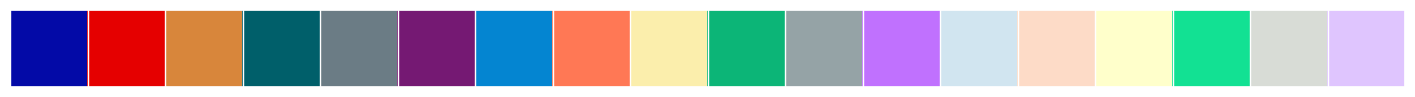

In [14]:
palette = [ "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", 
            "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#c071fe", 
            "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#dfc5fe", 
          ]
sns.palplot(sns.color_palette(palette))

In [15]:
repertoireRacine  = '.'
nomProjet         = "Titanic-Analyse exploratoire des données"

repertoireProjet  = os.path.join(repertoireRacine, nomProjet)
repertoireDonnees = os.path.join(repertoireProjet, 'repertoire.donnees')
repertoireImages  = os.path.join(repertoireProjet, 'repertoire.images')


def controleExistenceRepertoire( repertoire, create_if_needed=True):
    """Voir si le répertoire existe. S'il n'existe pas il est créé."""
    path_exists = os.path.exists(repertoire)
    if path_exists:
        if not os.path.isdir(repertoire):
            raise Exception("Trouvé le nom  "+repertoire +" mais c'est un fichier, pas un répertoire")
            # return False
        return True
    if create_if_needed:
        os.makedirs(repertoire)

def sauvegarderImage( fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    plt.savefig(os.path.join(repertoireImages,
                             fichier+f"--{dt.now().strftime('%Y_%m_%d_%H.%M.%S')}.png"), 
                             dpi=600, 
                             bbox_inches='tight')

def sauvegarderImageSNS( sns_plot, fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    fig = sns_plot.get_figure()
    fig.savefig(os.path.join(repertoireImages,fichier+'.png'))
    
controleExistenceRepertoire(repertoireProjet);
controleExistenceRepertoire(repertoireDonnees);
controleExistenceRepertoire(repertoireImages);

In [16]:
def formatPct(pct, allvals):
    total = int(round(pct/100. * np.sum(allvals)))
    return "{:.2f}%\n({:d})".format(pct, total)   

In [17]:
def affichageDistribution(colonne,couleur,ax, nom=''):
    graph = sns.distplot(colonne, color=couleur, ax=ax)
    graph.set(ylabel=None)
    moyenne, mediane = float(colonne.mean()), \
                   float(colonne.median())
    
    ax.axvline(moyenne, color='g', linestyle='-', label=f"{nom:12s} mean   = {moyenne:0.4f}", lw=2)
    ax.axvline(mediane, color='b', linestyle='--', label=f"{nom:12s} median = {mediane:0.4f}", lw=2)
    graph.legend(loc="upper right")

In [18]:
def afficheColonneCible(affiche:pd.DataFrame, colonne:str, cible:str, clouleurs:list, title:str):
    plt.figure(figsize=(24,12))
    graph = sns.countplot(x=colonne,
                          hue=cible,
                          data=affiche.sort_values([colonne,cible]),
                          palette=clouleurs);

    for patche in graph.patches:
        if patche.get_height() > 0 :
            graph.text(
                        patche.get_x()+0.2 ,
                        10 if int(patche.get_height()*0.3) < 10 else int(patche.get_height()*0.3),
                        int(patche.get_height()),
                        color='black',
                        rotation='vertical',
        #                 size='large',
        #                 fontsize='large',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.6),
                        verticalalignment='center',
                        horizontalalignment='center',
                       )       
    
    graph.set_ylabel('occurrences');
    graph.set_xlabel('');
    graph.set_title(title, y=1.05, size=36)
    # graph.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);    

In [19]:
def add_median_labels(ax, precision='.1f'):
    lines = ax.get_lines()
    # determine number of lines per box (this varies with/without fliers)
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    # iterate over median lines
    for median in lines[4:len(lines):lines_per_box]:
        # display median value at center of median line
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1]-median.get_xdata()[0]) == 0 else y
        text = ax.text(
                       x, 
                       y, 
                       f'{value:{precision}}', 
                       verticalalignment='center',
                       horizontalalignment='center', 
                       fontweight='bold', 
                       color='black',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.6),
                      )
        # créer une bordure de couleur médiane autour du texte blanc pour le contraste 
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])  

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Lecture des données</div></b>

<table>
    <tr> 
        <th  style="text-align:left">
            <table>
                <CAPTION style='padding:15px;color:#030aa7;font-size:150%;text-align: left;font-weight: bold;font-family: Georgia, serif'>
données d'entraînement (train.csv)<br>données de tests (test.csv)
</CAPTION>    
            <tr>                                                                                   
                <tr>                                                                                   
                     <th  style="text-align:left;background-color:#053061;color:white;">Colonne initiale </th>
                     <th  style="text-align:left;background-color:#053061;color:white;">Description</th>
                </tr>
                <tr>
                    <th  style="text-align:left;color:red;">survival</th>
                    <th  style="text-align:left;color:red;">Survie 0 = Non, 1 = Oui</th>
                </tr>
                <tr>
                    <th  style="text-align:left">pclass</th>
                    <th  style="text-align:left">Classe de billet 1 = 1er, 2 = 2e, 3 = 3e</th>
                </tr>
                <tr>
                    <th  style="text-align:left">name</th>
                    <th  style="text-align:left">Nom et titre du passager et les accompagnants</th>
                </tr>
                <tr>
                    <th  style="text-align:left">sex</th>
                    <th  style="text-align:left">Sexe</th>
                </tr>
                <tr>
                    <th  style="text-align:left">Age</th>
                    <th  style="text-align:left">Âge en années</th>
                </tr>
                <tr>
                    <th  style="text-align:left">sibsp</th>
                    <th  style="text-align:left">Nombre de frères et sœurs / conjoints à bord du Titanic</th>
                </tr>
                <tr>
                    <th  style="text-align:left">parch</th>
                    <th  style="text-align:left">Nombre de parents / enfants à bord du Titanic
ticket Numéro de billet</th>
                </tr>
                <tr>
                    <th  style="text-align:left">ticket</th>
                    <th  style="text-align:left">Numéro de billet</th>
                </tr>                
                <tr>
                    <th  style="text-align:left">fare</th>
                    <th  style="text-align:left">Tarif passager</th>
                </tr>
                <tr>
                    <th  style="text-align:left">cabin</th>
                    <th  style="text-align:left">Numéro de cabine</th>
                </tr>
                <tr>
                    <th  style="text-align:left">embarked</th>
                    <th  style="text-align:left">Port d'embarquement C = Cherbourg, Q = Queenstown, S = Southampton</th>
                </tr>
            </table>
        </th>
        <th  style="text-align:left"><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/titanic01.jpg" width="512"></th>
    </tr>
</table>

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Lecture des données d'entraînement</div></b>


In [20]:
train=pd.read_csv("train.csv", index_col="PassengerId")
print(train.shape)
train.sample(5)

(891, 11)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
70,0,3,"Kink, Mr. Vincenz",male,26.0,2,0,315151,8.6625,NaN,S
316,1,3,"Nilsson, Miss. Helmina Josefina",female,26.0,0,0,347470,7.8542,NaN,S
622,1,1,"Kimball, Mr. Edwin Nelson Jr",male,42.0,1,0,11753,52.5542,D19,S
111,0,1,"Porter, Mr. Walter Chamberlain",male,47.0,0,0,110465,52.0000,C110,S


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [22]:
train.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Lecture des données de tests</div></b>

In [23]:
test=pd.read_csv("test.csv", index_col="PassengerId")
print(test.shape)
test.sample(5)

(418, 10)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1142,2,"West, Miss. Barbara J",female,0.92,1,2,C.A. 34651,27.7500,NaN,S
1073,1,"Compton, Mr. Alexander Taylor Jr",male,37.00,1,1,PC 17756,83.1583,E52,C
1296,1,"Frauenthal, Mr. Isaac Gerald",male,43.00,1,0,17765,27.7208,D40,C
1043,3,"Matinoff, Mr. Nicola",male,NaN,0,0,349255,7.8958,NaN,C
1012,2,"Watt, Miss. Bertha J",female,12.00,0,0,C.A. 33595,15.7500,NaN,S


In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [25]:
test.isna().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Concaténation des deux jeux de données</div></b>

In [26]:
donnees = pd.concat([train,test],sort=False) #, ignore_index=True
donnees.rename(columns={"Pclass": "Classe", 
                        "SibSp": "ConjointsOuFratrie",
                        "Parch": "EnfantsOuParents", 
                        'Embarked':'Port'
                       },inplace=True)

In [27]:
donnees.Survived = donnees.Survived.fillna(-1).astype('int8').apply(lambda x : 'Test' if x == -1 else 'Non' if x == 0 else 'Oui')
donnees.Sex      = donnees.Sex.apply(lambda x : "Homme" if x == "male" else "Femme")
donnees.Classe   = donnees.Classe.apply( lambda x : 'Supérieure' if x == 1 else 'Moyenne' if x == 2 else 'Inférieure')

In [28]:
donnees.sample(10)

,Survived,Classe,Name,Sex,Age,ConjointsOuFratrie,EnfantsOuParents,Ticket,Fare,Cabin,Port
PassengerId,,,,,,,,,,,
651,Non,Inférieure,"Mitkoff, Mr. Mito",Homme,NaN,0,0,349221,7.8958,NaN,S
780,Oui,Supérieure,"Robert, Mrs. Edward Scott (Elisabeth Walton McMillan)",Femme,43.0,0,1,24160,211.3375,B3,S
915,Test,Supérieure,"Williams, Mr. Richard Norris II",Homme,21.0,0,1,PC 17597,61.3792,NaN,C
21,Non,Moyenne,"Fynney, Mr. Joseph J",Homme,35.0,0,0,239865,26.0000,NaN,S
20,Oui,Inférieure,"Masselmani, Mrs. Fatima",Femme,NaN,0,0,2649,7.2250,NaN,C
89,Oui,Supérieure,"Fortune, Miss. Mabel Helen",Femme,23.0,3,2,19950,263.0000,C23 C25 C27,S
279,Non,Inférieure,"Rice, Master. Eric",Homme,7.0,4,1,382652,29.1250,NaN,Q
970,Test,Moyenne,"Aldworth, Mr. Charles Augustus",Homme,30.0,0,0,248744,13.0000,NaN,S
1070,Test,Moyenne,"Becker, Mrs. Allen Oliver (Nellie E Baumgardner)",Femme,36.0,0,3,230136,39.0000,F4,S


In [29]:
donnees.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Survived            1309 non-null   object 
 1   Classe              1309 non-null   object 
 2   Name                1309 non-null   object 
 3   Sex                 1309 non-null   object 
 4   Age                 1046 non-null   float64
 5   ConjointsOuFratrie  1309 non-null   int64  
 6   EnfantsOuParents    1309 non-null   int64  
 7   Ticket              1309 non-null   object 
 8   Fare                1308 non-null   float64
 9   Cabin               295 non-null    object 
 10  Port                1307 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 122.7+ KB


In [30]:
donnees.isna().sum()

Survived                 0
Classe                   0
Name                     0
Sex                      0
Age                    263
ConjointsOuFratrie       0
EnfantsOuParents         0
Ticket                   0
Fare                     1
Cabin                 1014
Port                     2
dtype: int64

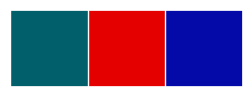

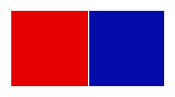

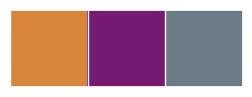

In [31]:
couleursSurvie = {nom:couleur for nom,couleur in zip([-1,0,1],["#005f6a","#e50000","#030aa7"])}
couleursSexe   = {nom:couleur for nom,couleur in zip(donnees.Sex.sort_values().unique(),["#e50000","#030aa7"])}
couleursPort   = {nom:couleur for nom,couleur in zip(donnees.Port.sort_values().unique(),["#d8863b", "#751973", "#6b7c85"])}
sns.palplot(sns.color_palette(couleursSurvie.values()))
sns.palplot(sns.color_palette(couleursSexe.values()))
sns.palplot(sns.color_palette(couleursPort.values()))

In [32]:
couleursSurvie, couleursSexe, couleursPort

({-1: '#005f6a', 0: '#e50000', 1: '#030aa7'},
 {'Femme': '#e50000', 'Homme': '#030aa7'},
 {'C': '#d8863b', 'Q': '#751973', 'S': '#6b7c85'})

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Ingénierie des variables</div></b>
## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Port d’embarquement</div></b>

In [33]:
donnees[donnees.Port.isna()]

,Survived,Classe,Name,Sex,Age,ConjointsOuFratrie,EnfantsOuParents,Ticket,Fare,Cabin,Port
PassengerId,,,,,,,,,,,
62,Oui,Supérieure,"Icard, Miss. Amelie",Femme,38.0,0,0,113572,80.0,B28,NaN
830,Oui,Supérieure,"Stone, Mrs. George Nelson (Martha Evelyn)",Femme,62.0,0,0,113572,80.0,B28,NaN


In [34]:
donnees[donnees.Ticket == '113572']

,Survived,Classe,Name,Sex,Age,ConjointsOuFratrie,EnfantsOuParents,Ticket,Fare,Cabin,Port
PassengerId,,,,,,,,,,,
62,Oui,Supérieure,"Icard, Miss. Amelie",Femme,38.0,0,0,113572,80.0,B28,NaN
830,Oui,Supérieure,"Stone, Mrs. George Nelson (Martha Evelyn)",Femme,62.0,0,0,113572,80.0,B28,NaN


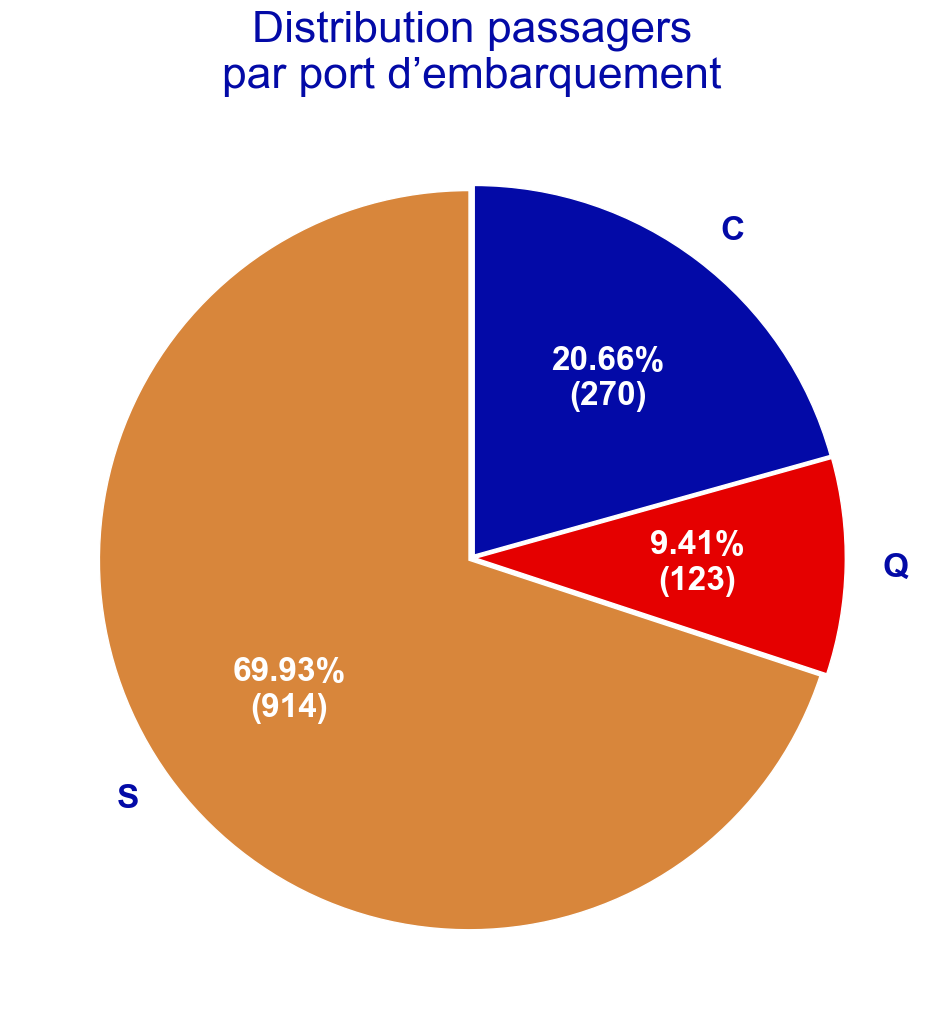

In [35]:
radius,size=0.8,0.3
fig,ax = plt.subplots(ncols=1,figsize=(12,12), subplot_kw=dict(aspect="equal"))

affichage = donnees.groupby('Port').Name.count().reset_index().rename(columns={'Name':'nombre'})
affichage['%'] = affichage.nombre * 100 / affichage.nombre.sum()
affichage

wedges, texts, autotexts =  ax.pie(
         affichage['nombre'],
         autopct=lambda pct: formatPct(pct, affichage.nombre.values),   # autopct='%1.2f%%', 
         labels=affichage.Port.values,
         # shadow=True, 
         counterclock=False,
         startangle=90 ,
         colors = palette,
         # pctdistance=0.4, 
         labeldistance=1.1, 
         textprops=dict(color="#030aa7"),
         explode=[0.01 for _ in range(affichage.Port.count())]
      );
plt.setp(autotexts, size=24, weight="bold",color="w")
plt.setp(texts, size=24, weight="bold");
ax.set_title("Distribution passagers\npar port d’embarquement",fontdict=dict(color="#030aa7", size=32));

In [36]:
donnees['Port'] = donnees.Port.fillna('S').apply(lambda x : 'Cherbourg'   if x == 'C' 
                                                    else 'Queenstown'  if x == 'Q' 
                                                    else 'Southampton' )

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Nom des passagers</div></b>

In [37]:
donnees.Name.sample(5)

PassengerId
463                         Gee, Mr. Arthur H
552               Sharp, Mr. Percival James R
109                           Rekic, Mr. Tido
634             Parr, Mr. William Henry Marsh
686    Laroche, Mr. Joseph Philippe Lemercier
Name: Name, dtype: object

In [38]:
donnees['Title'] = donnees.Name.str.extract(', ([A-Za-z]+)\.', expand=False) 

In [39]:
pd.crosstab(donnees['Title'], donnees['Sex']).style.format("{:d}").background_gradient(cmap=plt.get_cmap('Blues'),axis=0)

Sex,Femme,Homme
Title,,
Capt,0,1
Col,0,4
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,61


In [40]:
donnees['Title'] = donnees.Name.str.extract(', ([A-Za-z]+)\.', expand=False) 
# donnees['Title'] = donnees['Title'].replace(['Dr','Rev'],'Soigneur')
# donnees['Title'] = donnees['Title'].replace(['Capt','Col','Major'], 'Militaire')
# donnees['Title'] = donnees['Title'].replace(['Lady', 'Countess',  'Don',  'Sir', 'Jonkheer', 'Dona'], 'Noblesse')
donnees['Title'] = donnees['Title'].replace(['Lady', 'Countess',  'Don',  'Sir', 'Jonkheer', 
                                             'Dona','Capt','Col','Major', 'Dr','Rev'], 'Noblesse')
donnees['Title'] = donnees['Title'].replace('Mlle', 'Miss')
donnees['Title'] = donnees['Title'].replace('Ms', 'Miss')
donnees['Title'] = donnees['Title'].replace('Mme', 'Mrs')
pd.crosstab(donnees['Title'], donnees['Sex']).style.format("{:d}").background_gradient(cmap=plt.get_cmap('Blues'),axis=0)

Sex,Femme,Homme
Title,,
Master,0,61
Miss,264,0
Mr,0,757
Mrs,198,0
Noblesse,3,25


In [41]:
donnees.Name = donnees.Name.str.extract('([A-Za-z]+)\,', expand=False)
donnees.head()

,Survived,Classe,Name,Sex,Age,ConjointsOuFratrie,EnfantsOuParents,Ticket,Fare,Cabin,Port,Title
PassengerId,,,,,,,,,,,,
1,Non,Inférieure,Braund,Homme,22.0,1,0,A/5 21171,7.2500,NaN,Southampton,Mr
2,Oui,Supérieure,Cumings,Femme,38.0,1,0,PC 17599,71.2833,C85,Cherbourg,Mrs
3,Oui,Inférieure,Heikkinen,Femme,26.0,0,0,STON/O2. 3101282,7.9250,NaN,Southampton,Miss
4,Oui,Supérieure,Futrelle,Femme,35.0,1,0,113803,53.1000,C123,Southampton,Mrs
5,Non,Inférieure,Allen,Homme,35.0,0,0,373450,8.0500,NaN,Southampton,Mr


### <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Titre</div></b>

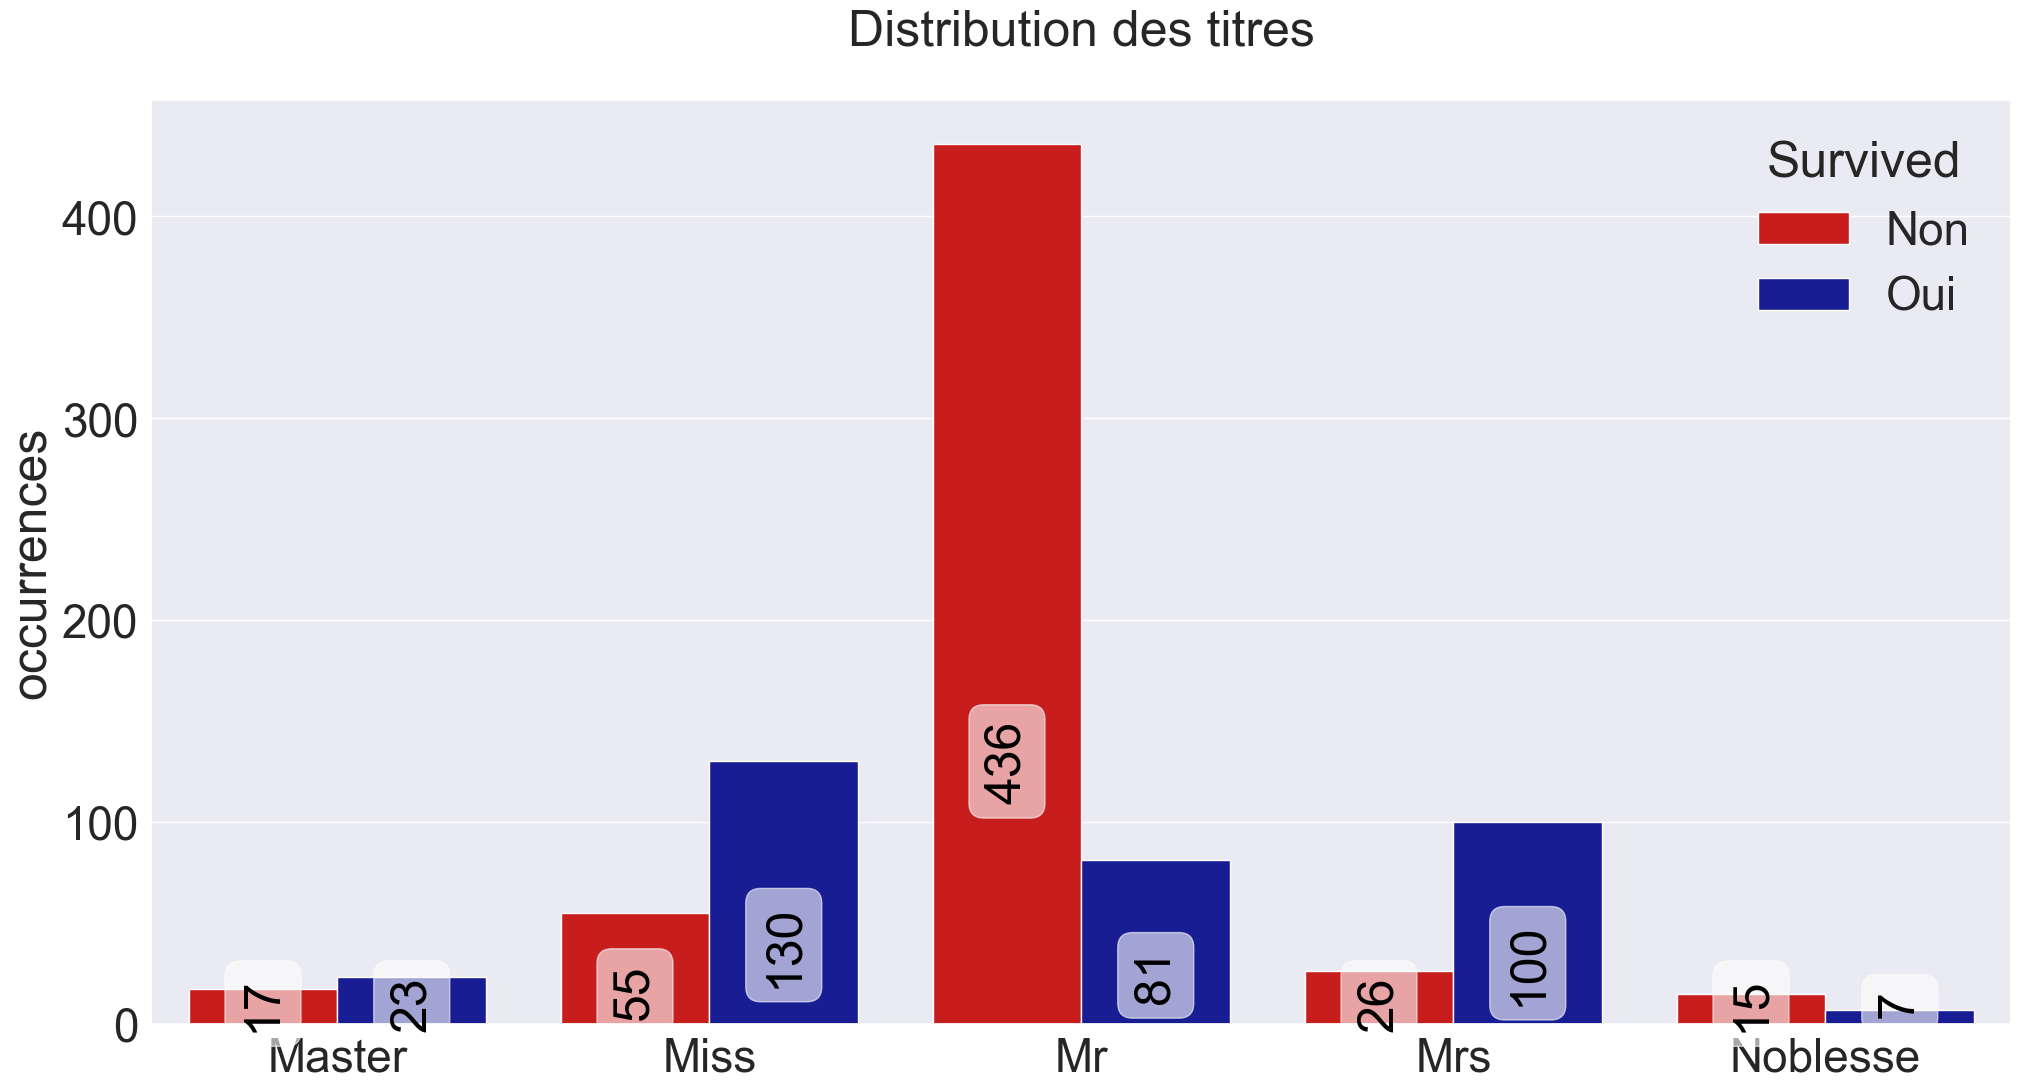

In [42]:
afficheColonneCible(donnees[donnees.Survived != 'Test'], 
                    colonne='Title', 
                    cible='Survived', 
                    clouleurs=list(couleursSurvie.values())[1:], 
                    title='Distribution des titres')

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Taille de la famille</div></b>

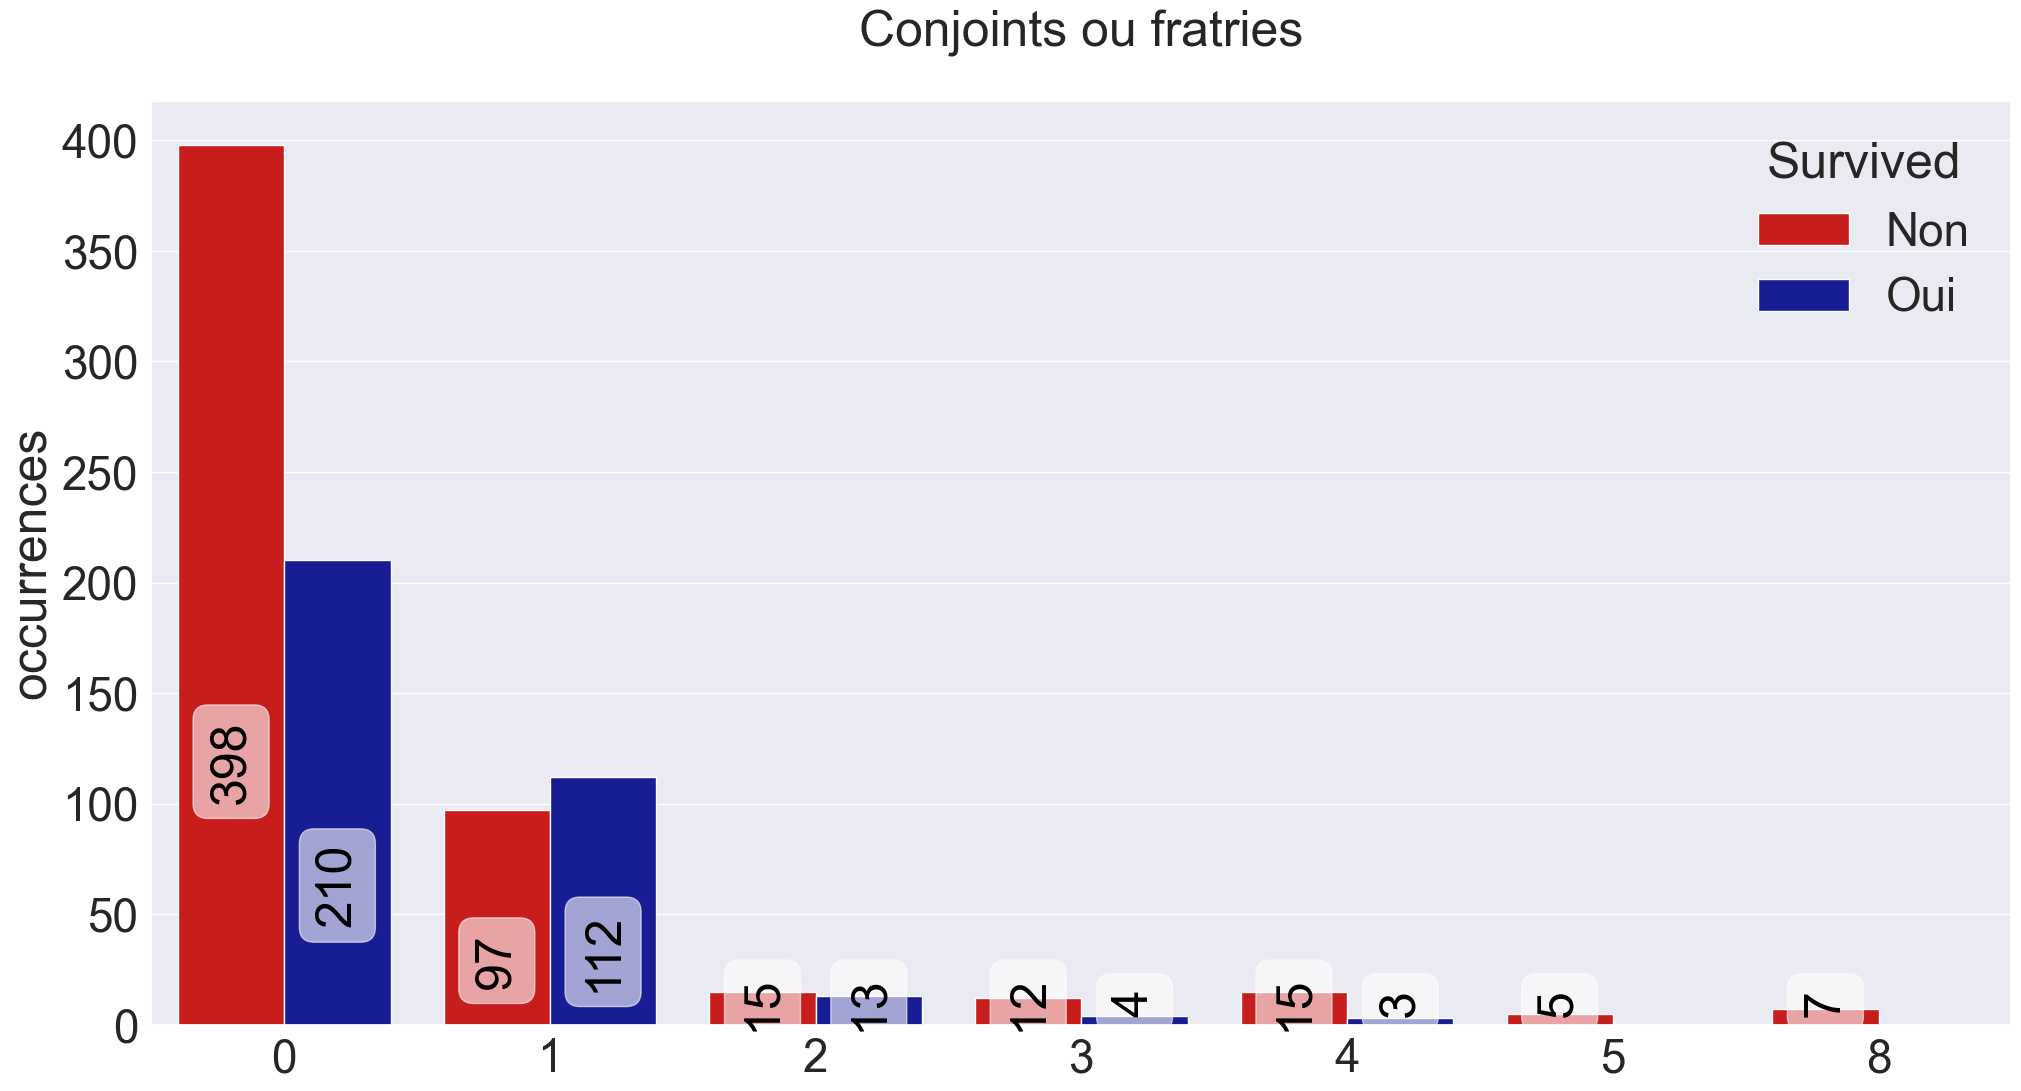

In [43]:
afficheColonneCible(donnees[donnees.Survived != 'Test'], 
                    colonne='ConjointsOuFratrie', 
                    cible='Survived', 
                    clouleurs=list(couleursSurvie.values())[1:], 
                    title='Conjoints ou fratries')

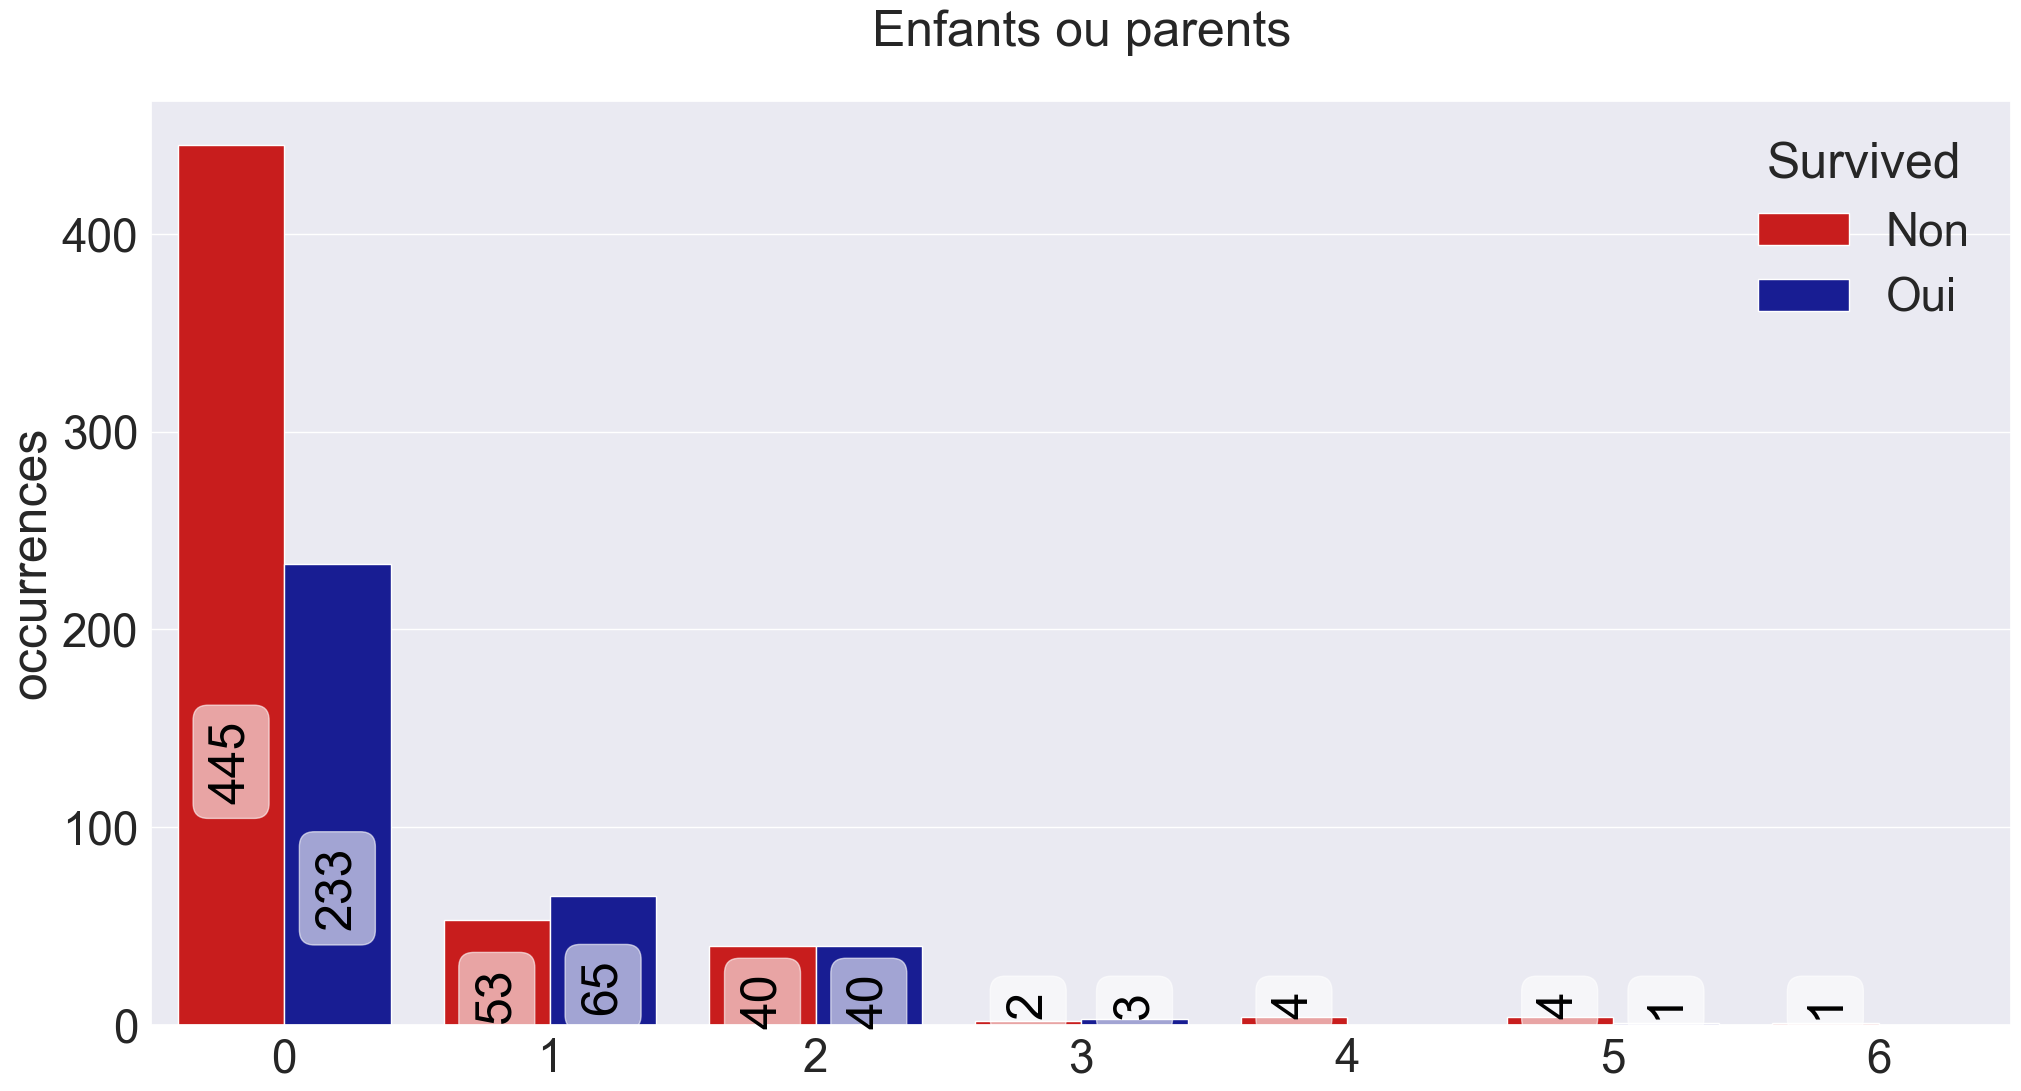

In [44]:
afficheColonneCible(donnees[donnees.Survived != 'Test'], 
                    colonne='EnfantsOuParents', 
                    cible='Survived', 
                    clouleurs=list(couleursSurvie.values())[1:], 
                    title='Enfants ou parents')

In [45]:
donnees['TailleFamille'] = donnees['ConjointsOuFratrie'] + donnees['EnfantsOuParents'] + 1
donnees.TailleFamille = donnees.TailleFamille.astype('int8')

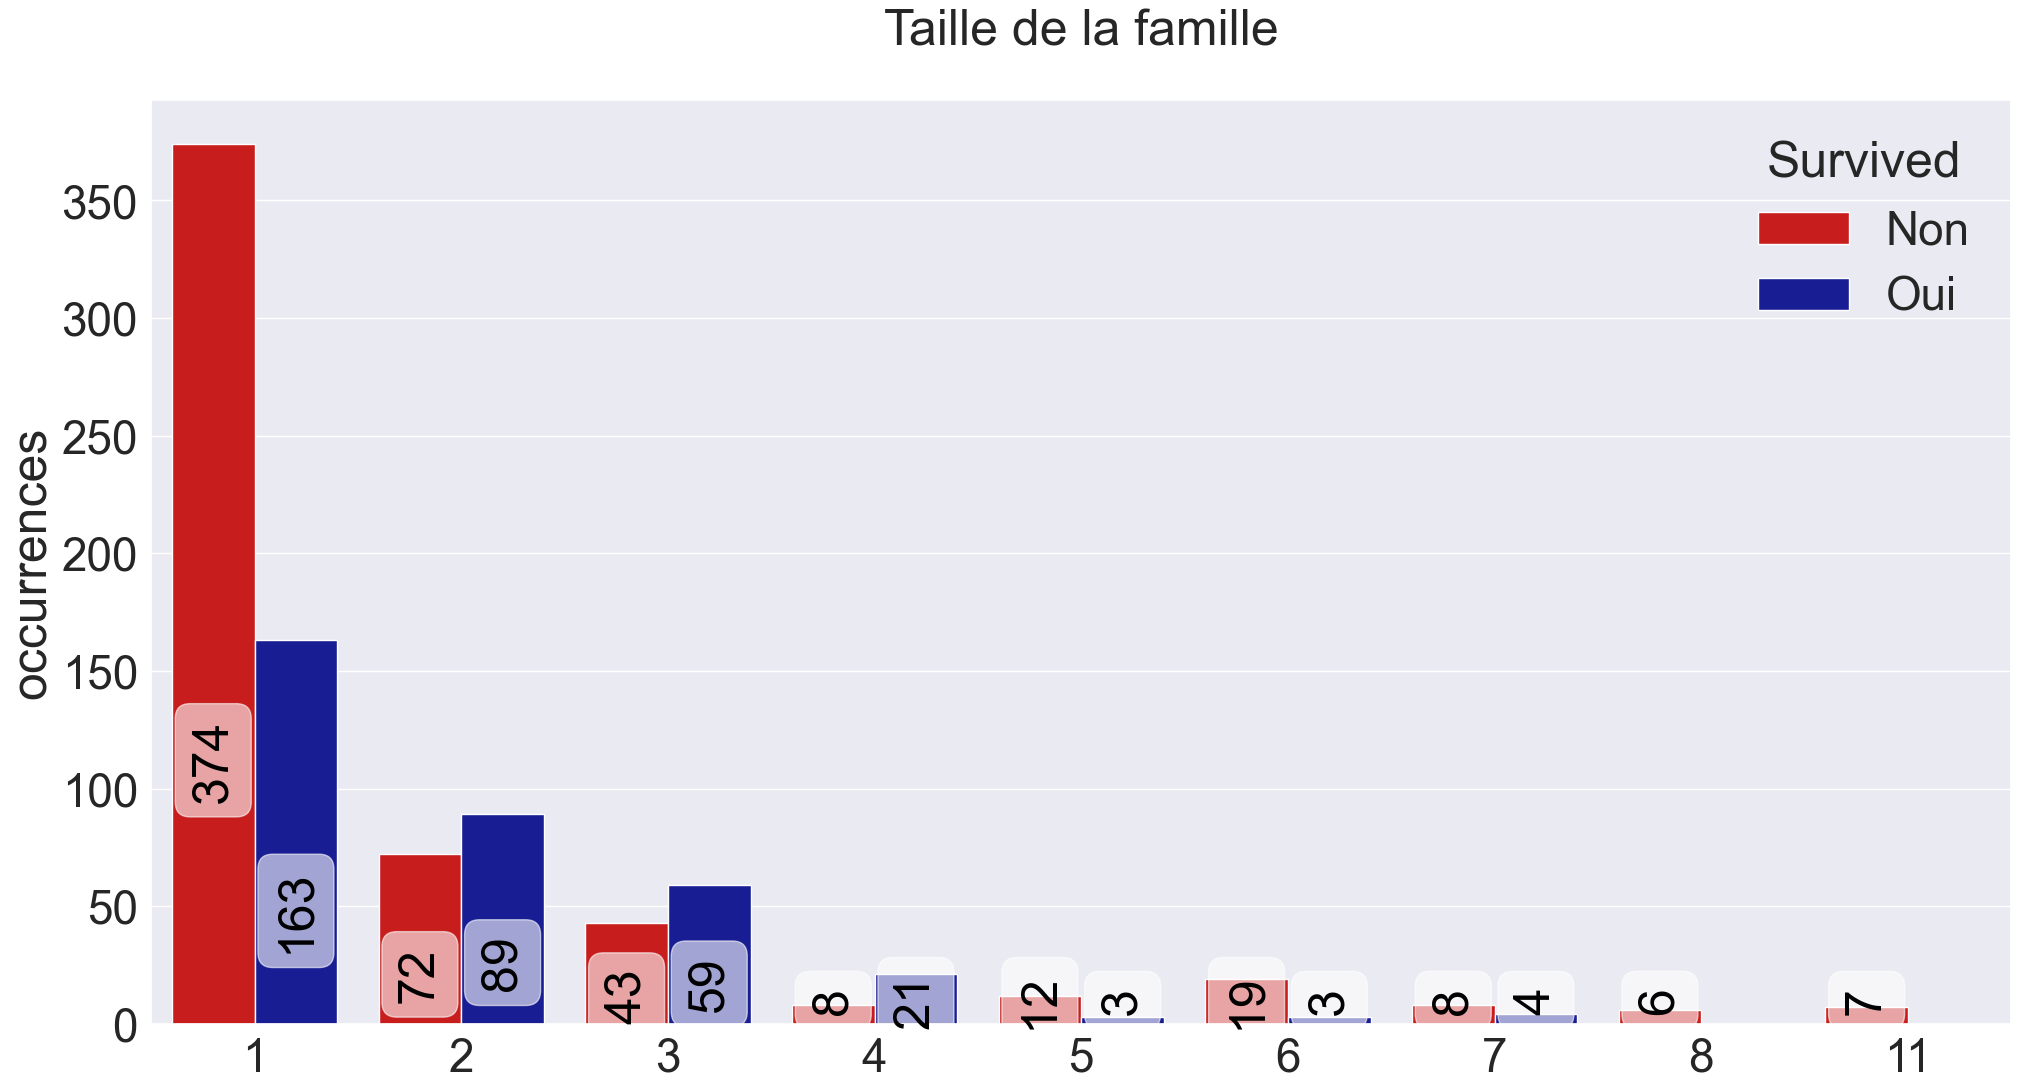

In [46]:
afficheColonneCible(donnees[donnees.Survived != 'Test'], 
                    colonne='TailleFamille', 
                    cible='Survived', 
                    clouleurs=list(couleursSurvie.values())[1:], 
                    title='Taille de la famille')

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Pont</div></b>

In [47]:
donnees['Pont'] = donnees.Cabin.str.extract('([A-Za-z])', expand=False)
donnees.Pont = donnees.Pont.fillna('Vide')
pd.crosstab(donnees.Pont, np.ones(donnees.shape[0])).style.format("{:d}").background_gradient(cmap=plt.get_cmap('Blues'),axis=0)

col_0,1.000000
Pont,
A,22
B,65
C,94
D,46
E,41
F,21
G,5
T,1
Vide,1014


## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Cabine</div></b>

In [48]:
donnees['Cabin'] = donnees["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
donnees.rename(columns={'Cabin':'Cabine'},inplace=True)

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Ticket</div></b>

In [49]:
donnees['TicketNum'] = donnees.Ticket.replace(regex=r'([^0-9]+)',value='')

In [50]:
donnees.Ticket = donnees.Ticket.replace(regex=r'([^a-zA-Z]+)',value='')
donnees.Ticket = donnees.Ticket.replace({r'^(CASOTON|SOTONO|STONO|STONOQ)$':'SOTONOQ', 
                                         r'^(SC|SCParis)$':'SCPARIS', 
                                         r'^FCC$':'FC',
                                         r'^$':'Vide'}, regex=True) 

In [51]:
pd.crosstab(donnees.Ticket, np.ones(donnees.shape[0])).style.format("{:d}").background_gradient(cmap=plt.get_cmap('Blues'),axis=0)

col_0,1.000000
Ticket,
A,39
AQ,2
AS,1
C,8
CA,68
FC,12
Fa,1
LINE,4
LP,1


## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Voyageurs en groupe</div></b>

In [52]:
donnees['TitreFamille'] = donnees.apply(lambda ligne : 'Homme' if ligne['Title'] == 'Mr'
                                                               else 'Femme' if ligne['Sex'] == 'Femme'
                                                               else 'Garçon' if ligne['Title'] == 'Master'
                                                               else 'Homme' , axis=1)

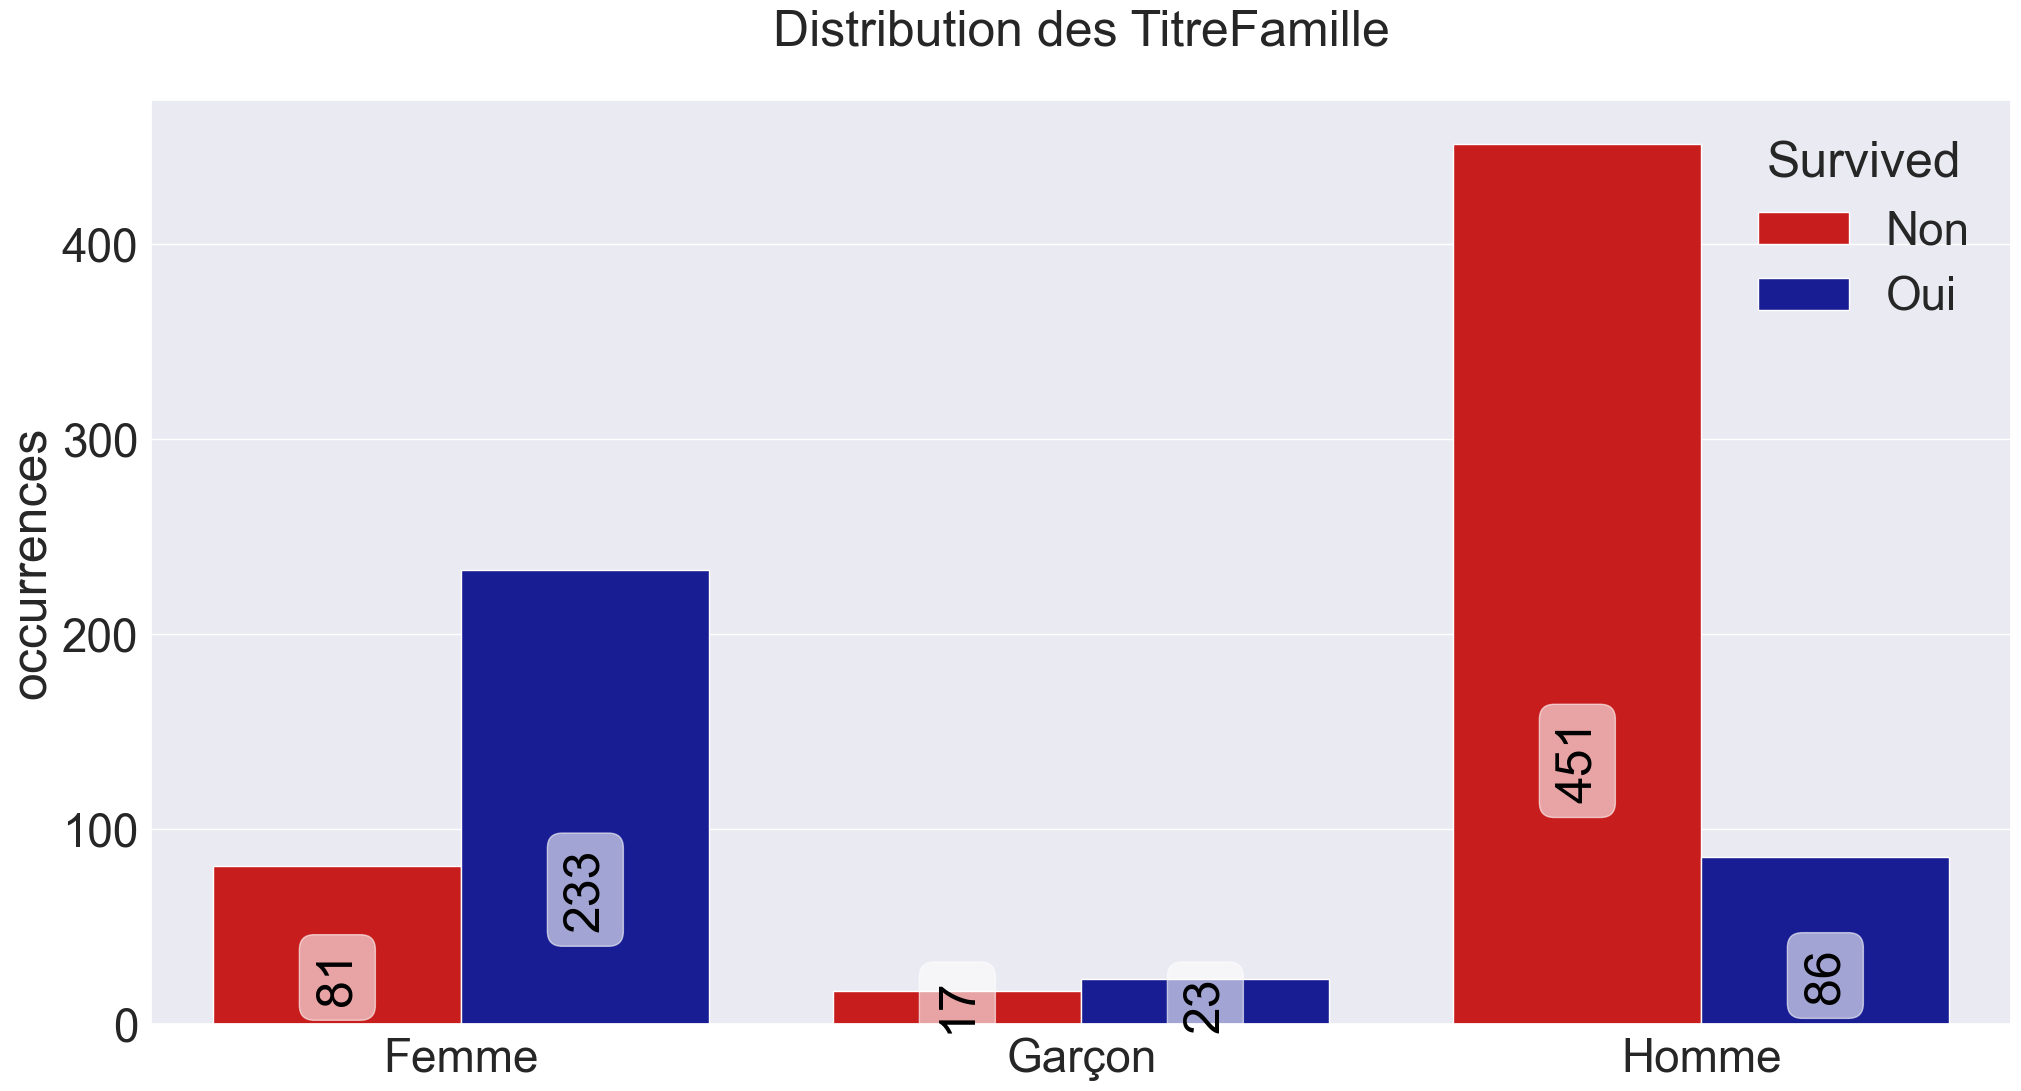

In [53]:
afficheColonneCible(donnees[donnees.Survived != 'Test'], 
                    colonne='TitreFamille', 
                    cible='Survived', 
                    clouleurs=list(couleursSurvie.values())[1:], 
                    title='Distribution des TitreFamille')

### <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Groupe Famille</div></b>

In [54]:
donnees['GroupFamille'] = donnees.Name+'-'+\
                          donnees.Classe+'-'+\
                          donnees.Port+'-'+\
                          donnees.Ticket
donnees['GroupFamille'][donnees.TailleFamille == 1] = 'Sans Groupe'
donnees['GroupFamilleFreq'] = donnees.groupby('GroupFamille')['GroupFamille'].transform('count')
donnees.loc[donnees.GroupFamille == 'Sans Groupe','GroupFamilleFreq'] = 0

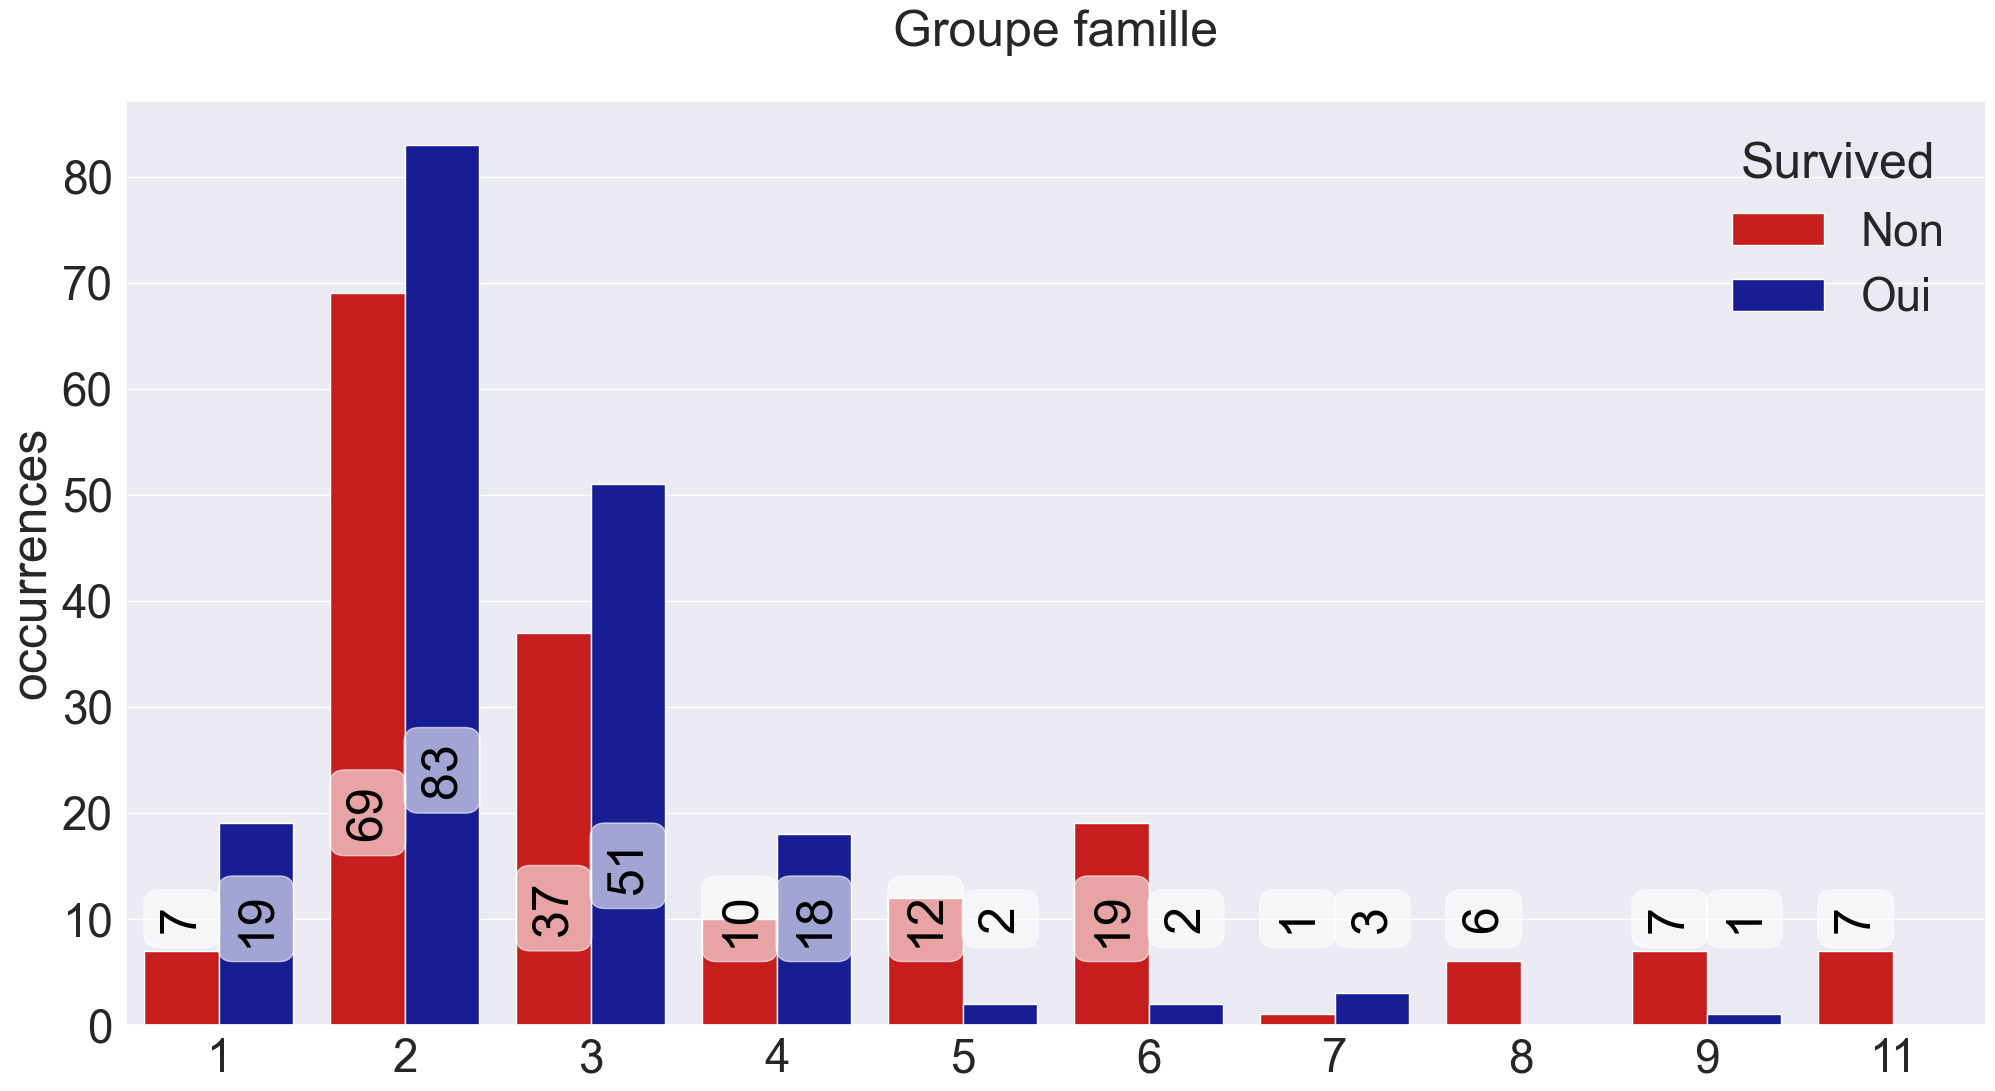

In [55]:
afficheColonneCible(donnees[(donnees.Survived != 'Test')&(donnees.GroupFamille != 'Sans Groupe')], 
                    colonne='GroupFamilleFreq', 
                    cible='Survived', 
                    clouleurs=list(couleursSurvie.values())[1:], 
                    title='Groupe famille')

### <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Groupe femme avec enfant</div></b>

In [56]:
donnees['GroupFemmeEnfant'] = donnees['GroupFamille']
donnees['GroupFemmeEnfant'][donnees.TitreFamille == 'Homme'] = 'Sans Groupe'
donnees['GroupFemmeEnfantFreq'] = donnees.groupby('GroupFemmeEnfant')['GroupFemmeEnfant'].transform('count')
donnees.loc[donnees.GroupFemmeEnfant == 'Sans Groupe','GroupFemmeEnfantFreq'] = 0

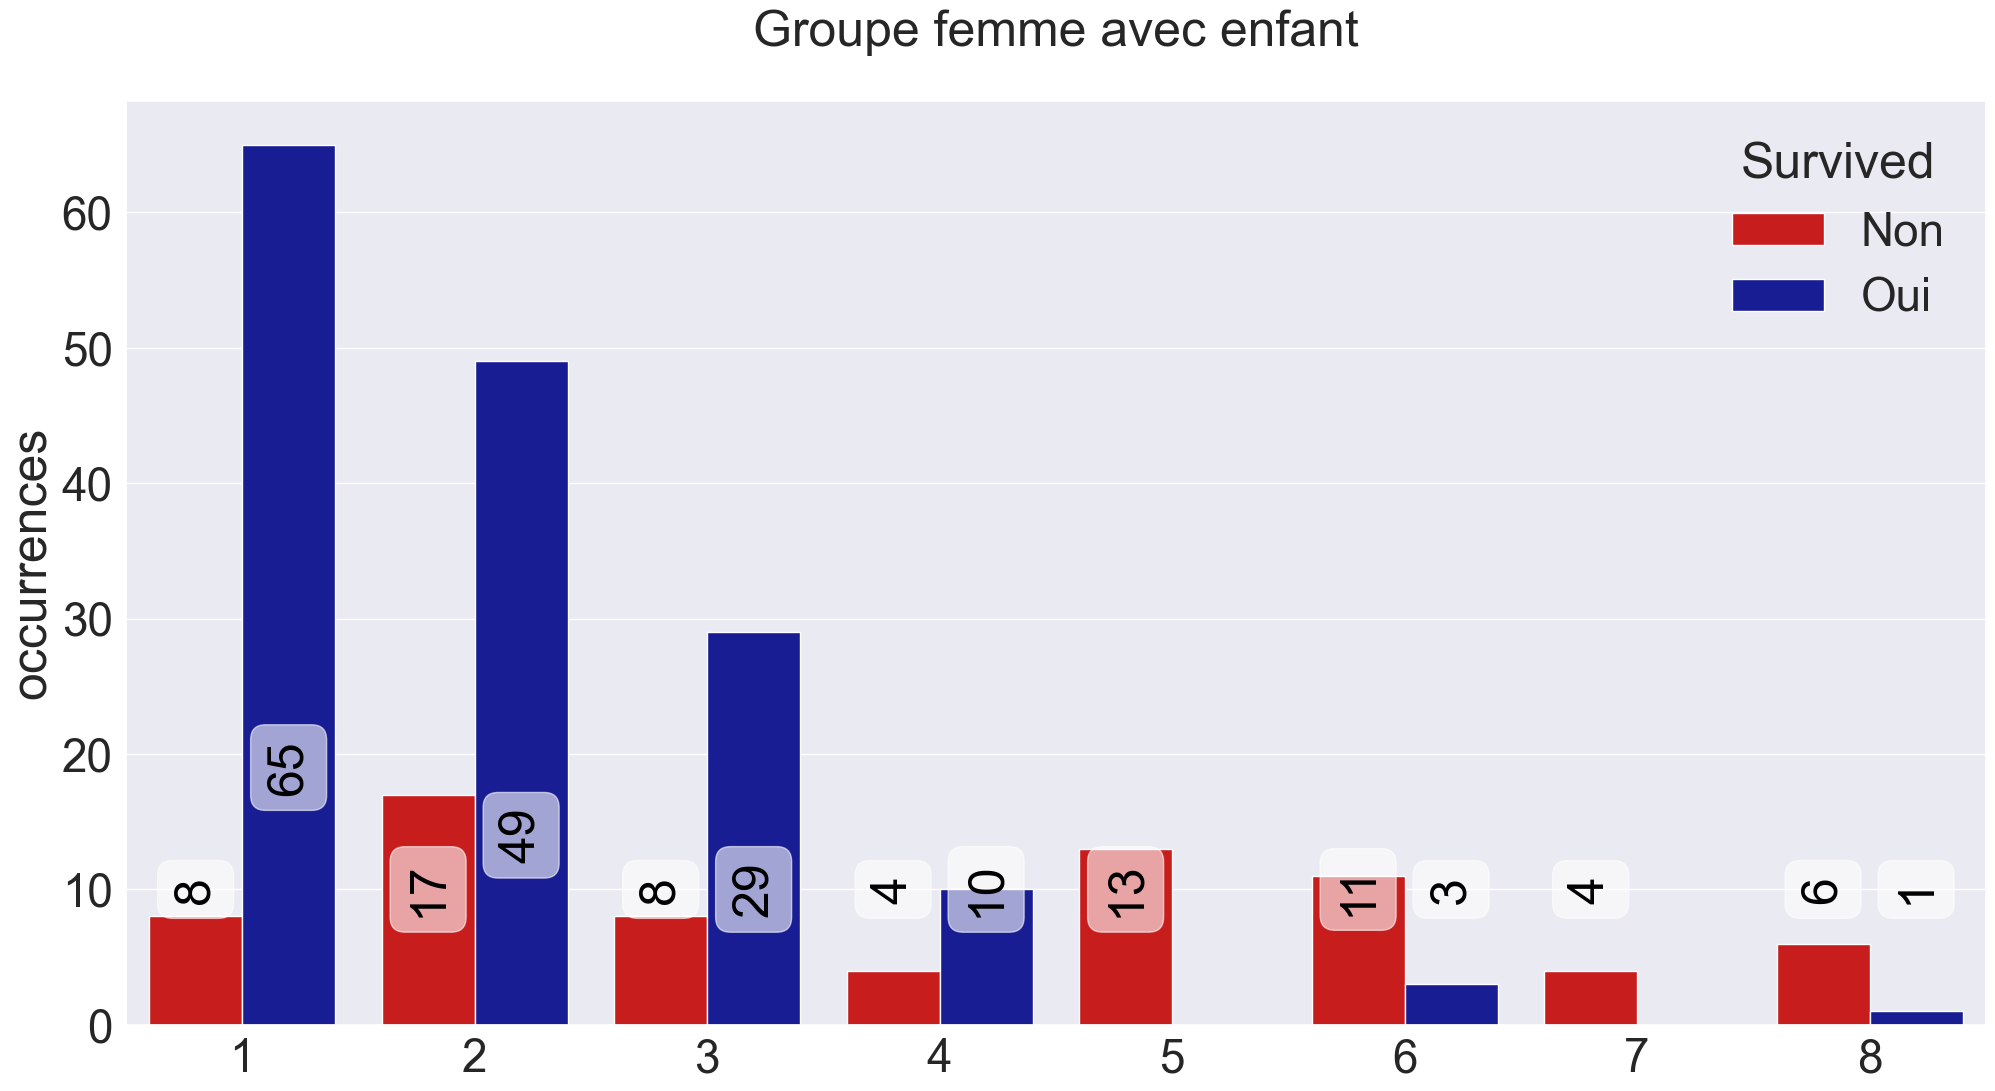

In [57]:
afficheColonneCible(donnees[(donnees.Survived != 'Test')&(donnees.GroupFemmeEnfantFreq > 0)], 
                    colonne='GroupFemmeEnfantFreq', 
                    cible='Survived', 
                    clouleurs=list(couleursSurvie.values())[1:], 
                    title='Groupe femme avec enfant')

### <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Groupe femme enfant et gouvernante</div></b>

In [58]:
donnees['GroupFemmeEnfGouv']  = donnees.Classe+'-'+\
                                donnees.Port+'-'+\
                                donnees.TicketNum
donnees['GroupFemmeEnfGouv'][donnees.TitreFamille == 'Homme'] = 'Sans Groupe'
donnees['GroupFemmeEnfGouvFreq'] = donnees.groupby('GroupFemmeEnfGouv')['GroupFemmeEnfGouv'].transform('count')
donnees.loc[donnees.GroupFemmeEnfGouv == 'Sans Groupe','GroupFemmeEnfGouvFreq'] = 0

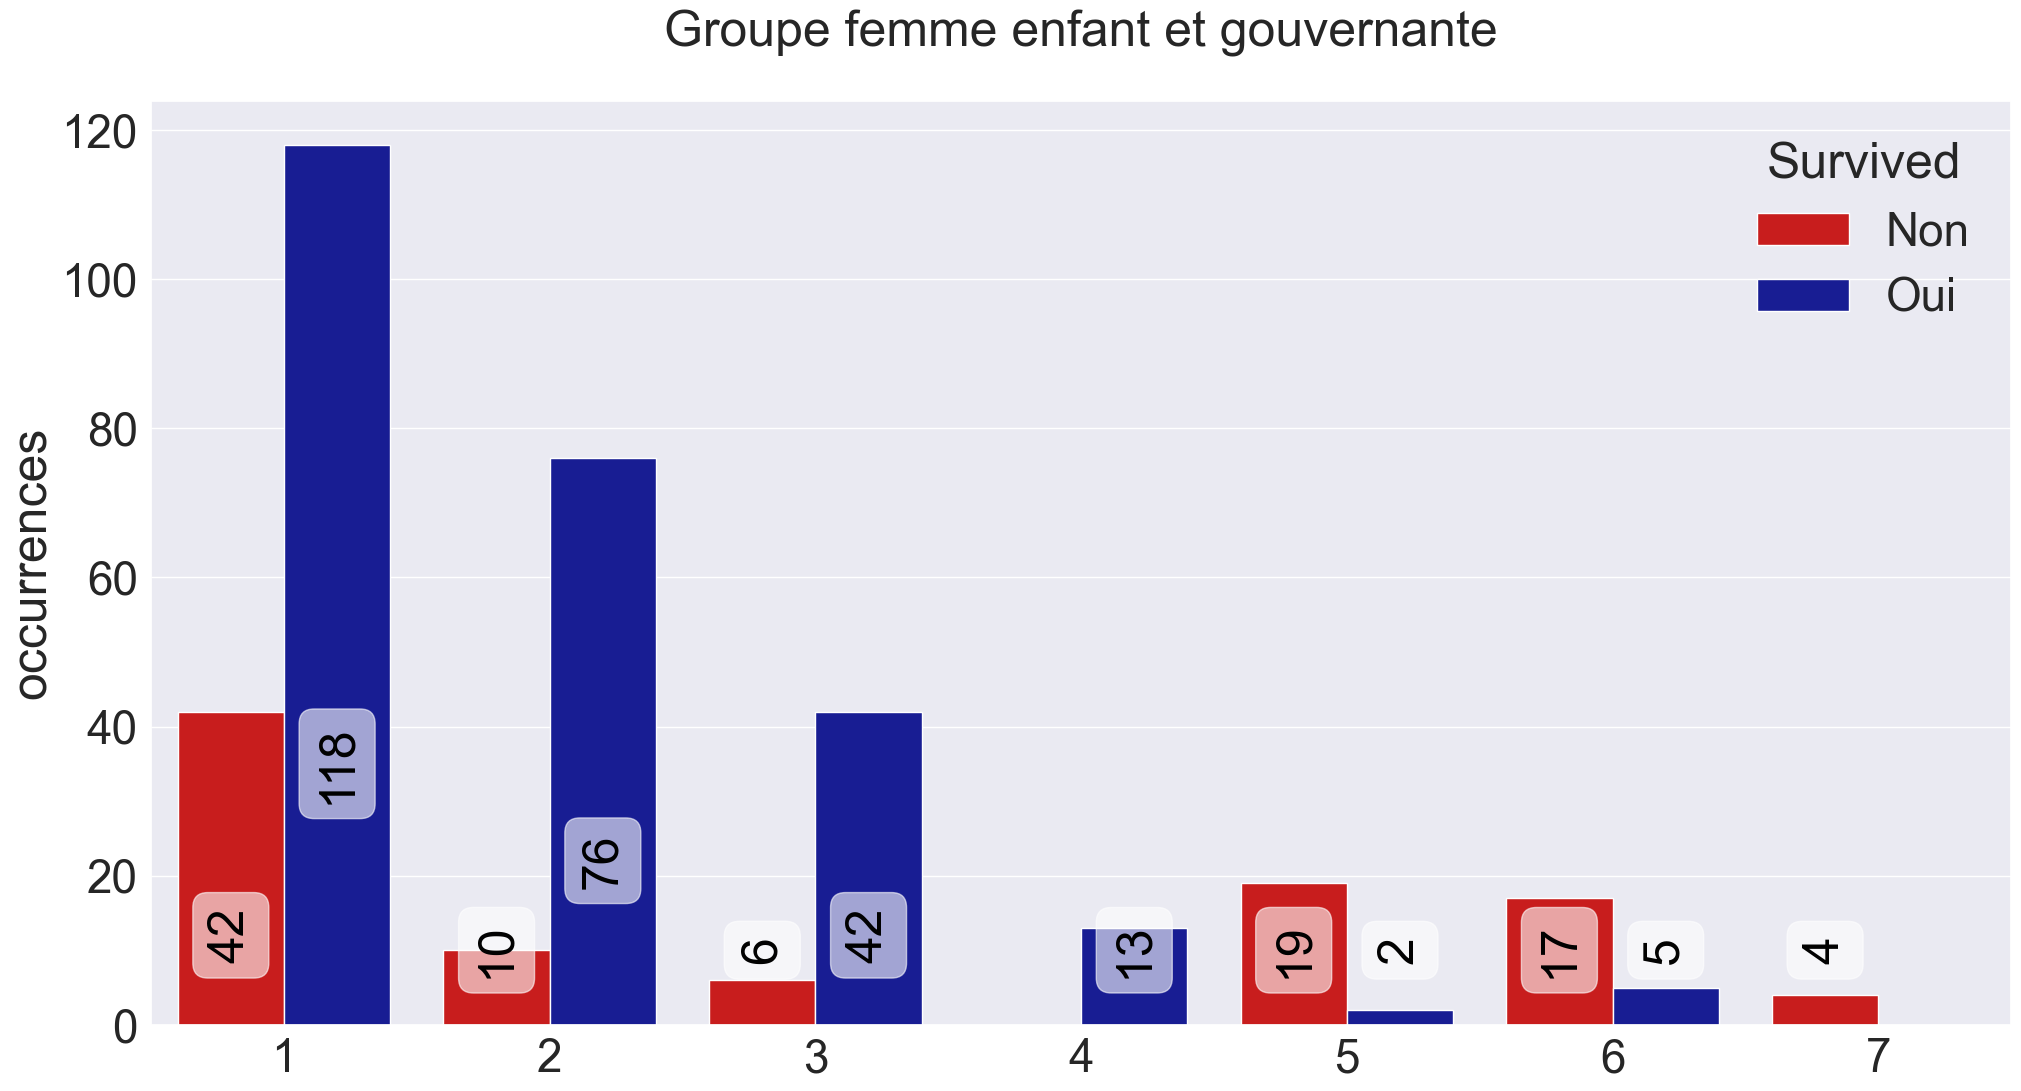

In [59]:
afficheColonneCible(donnees[(donnees.Survived != 'Test')&(donnees.GroupFemmeEnfGouvFreq > 0)], 
                    colonne='GroupFemmeEnfGouvFreq', 
                    cible='Survived', 
                    clouleurs=list(couleursSurvie.values())[1:], 
                    title='Groupe femme enfant et gouvernante')

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Autres recherches</div></b>

<div style='padding:15px;color:#030aa7;font-size:100%;text-align: left;font-family: Georgia, serif'>
<img src="https://vignette.wikia.nocookie.net/titanic/images/f/f9/Titanic_side_plan.png/revision/latest?cb=20180322183733" width="1024"><br>
Sur le pont des bateaux, il y avait <b>6</b> cabines étiquetées <b>T, U, W, X, Y, Z</b> mais seule la cabine <b>T</b> est présente dans l'ensemble de données

>> Les ponts **A**, **B** et **C** étaient uniquement destinés aux passagers de 1ère classe
>> Les ponts **D** et **E** étaient destinés à toutes les classes
>> Les ponts **F** et **G** étaient destinés aux passagers de 2e et 3e classe
>> En passant de **A** à **G**, la distance jusqu'à l'escalier augmente, ce qui pourrait être un facteur de survie    
</div>

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Traitement du prix non renseigné</div></b>

In [60]:
donnees.loc[donnees.Fare.isnull(), ['Survived', 'Classe', 'Name', 'Sex', 'Age', 'TailleFamille', 'Fare', 'Port', 'Title']]

,Survived,Classe,Name,Sex,Age,TailleFamille,Fare,Port,Title
PassengerId,,,,,,,,,
1044,Test,Inférieure,Storey,Homme,60.5,1,NaN,Southampton,Mr


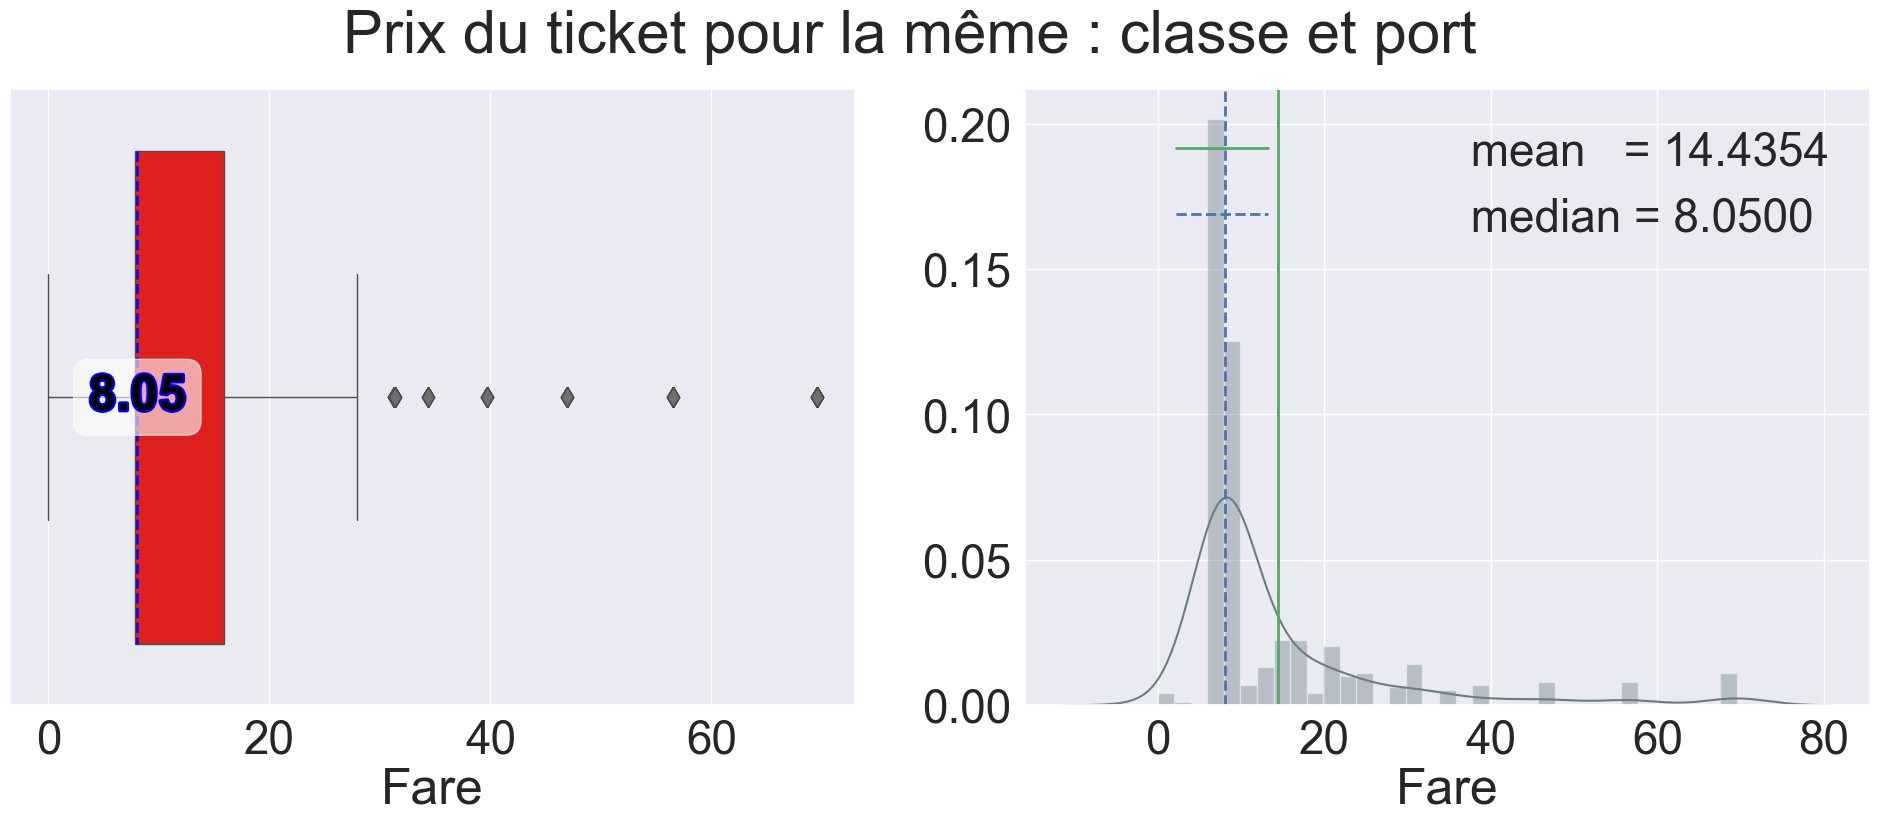

In [61]:
affichage = donnees.loc[(donnees.Port == 'Southampton')&(donnees.Classe == 'Inférieure'), :]

fig, ax = plt.subplots(1,2, figsize=(24,8));

sns.boxplot(x=affichage.Fare,
            color='red', 
            medianprops = dict(color="blue", linewidth=2, alpha=0.9, linestyle='--'),
            flierprops  = dict(markerfacecolor="#707070", marker="d"),
            fliersize   = 10,
            ax=ax[0]
           )
add_median_labels(ax[0], precision='.2f')

affichageDistribution(affichage.Fare,"#6b7c85",ax[1])

fig.suptitle("Prix du ticket pour la même : classe et port");

In [62]:
donnees.loc[donnees.Fare.isnull(), 'Fare'] = affichage.Fare.median()

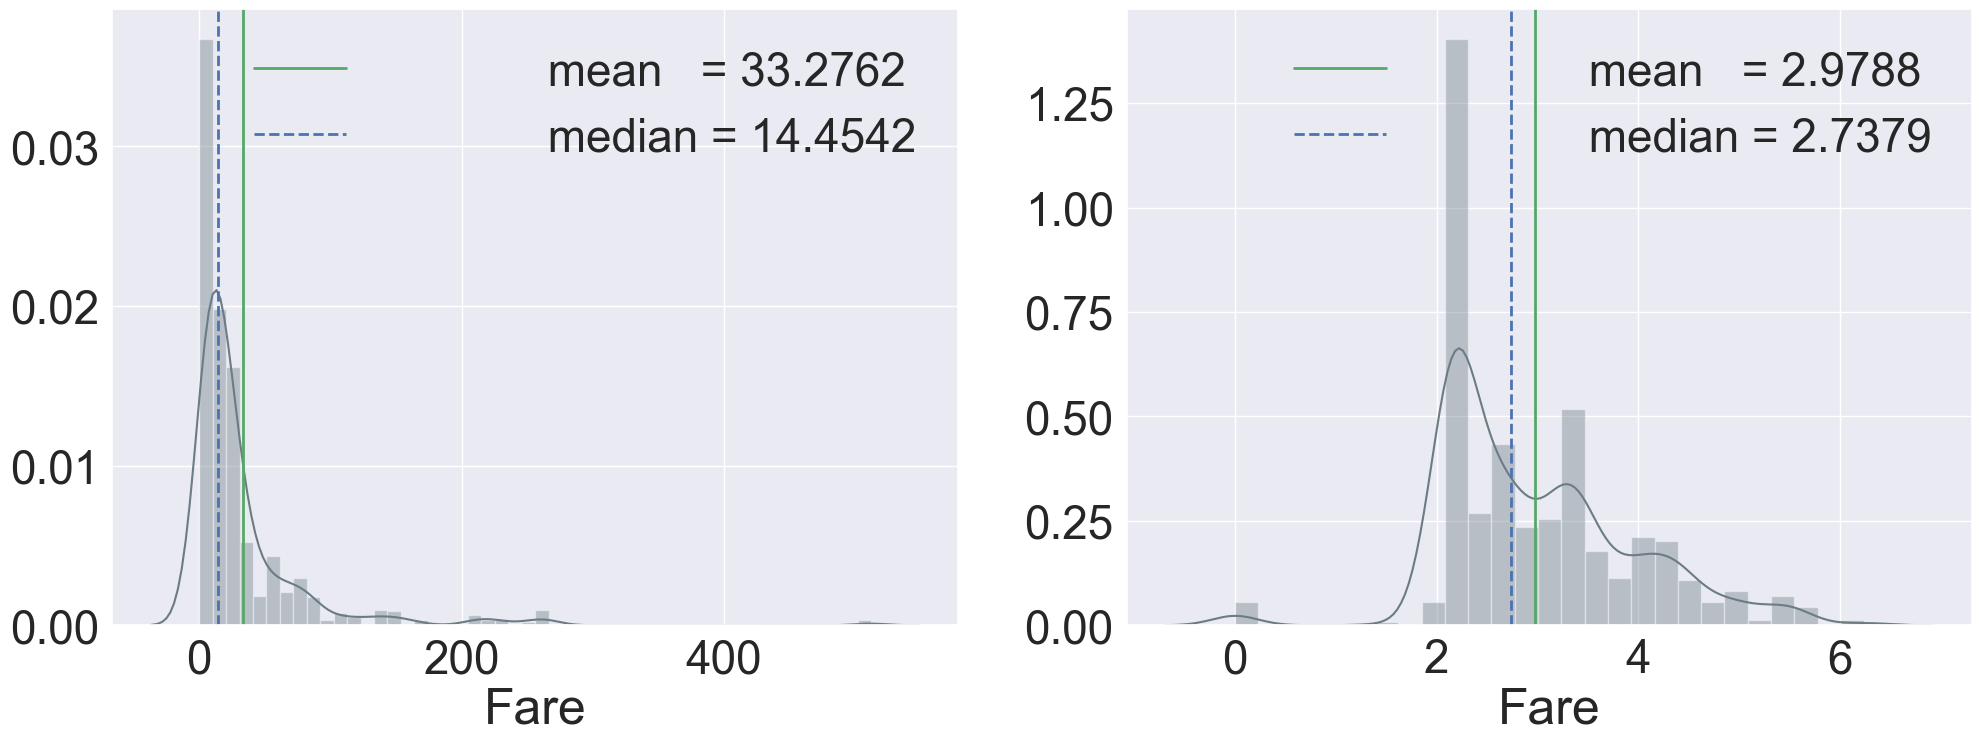

In [63]:
fig, ax = plt.subplots(1,2, figsize=(24,8));
affichageDistribution(donnees.Fare,"#6b7c85",ax[0])
affichageDistribution(np.log(donnees.Fare+1),"#6b7c85",ax[1])

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Traitement des enregistrements avec Age non renseigné</div></b>

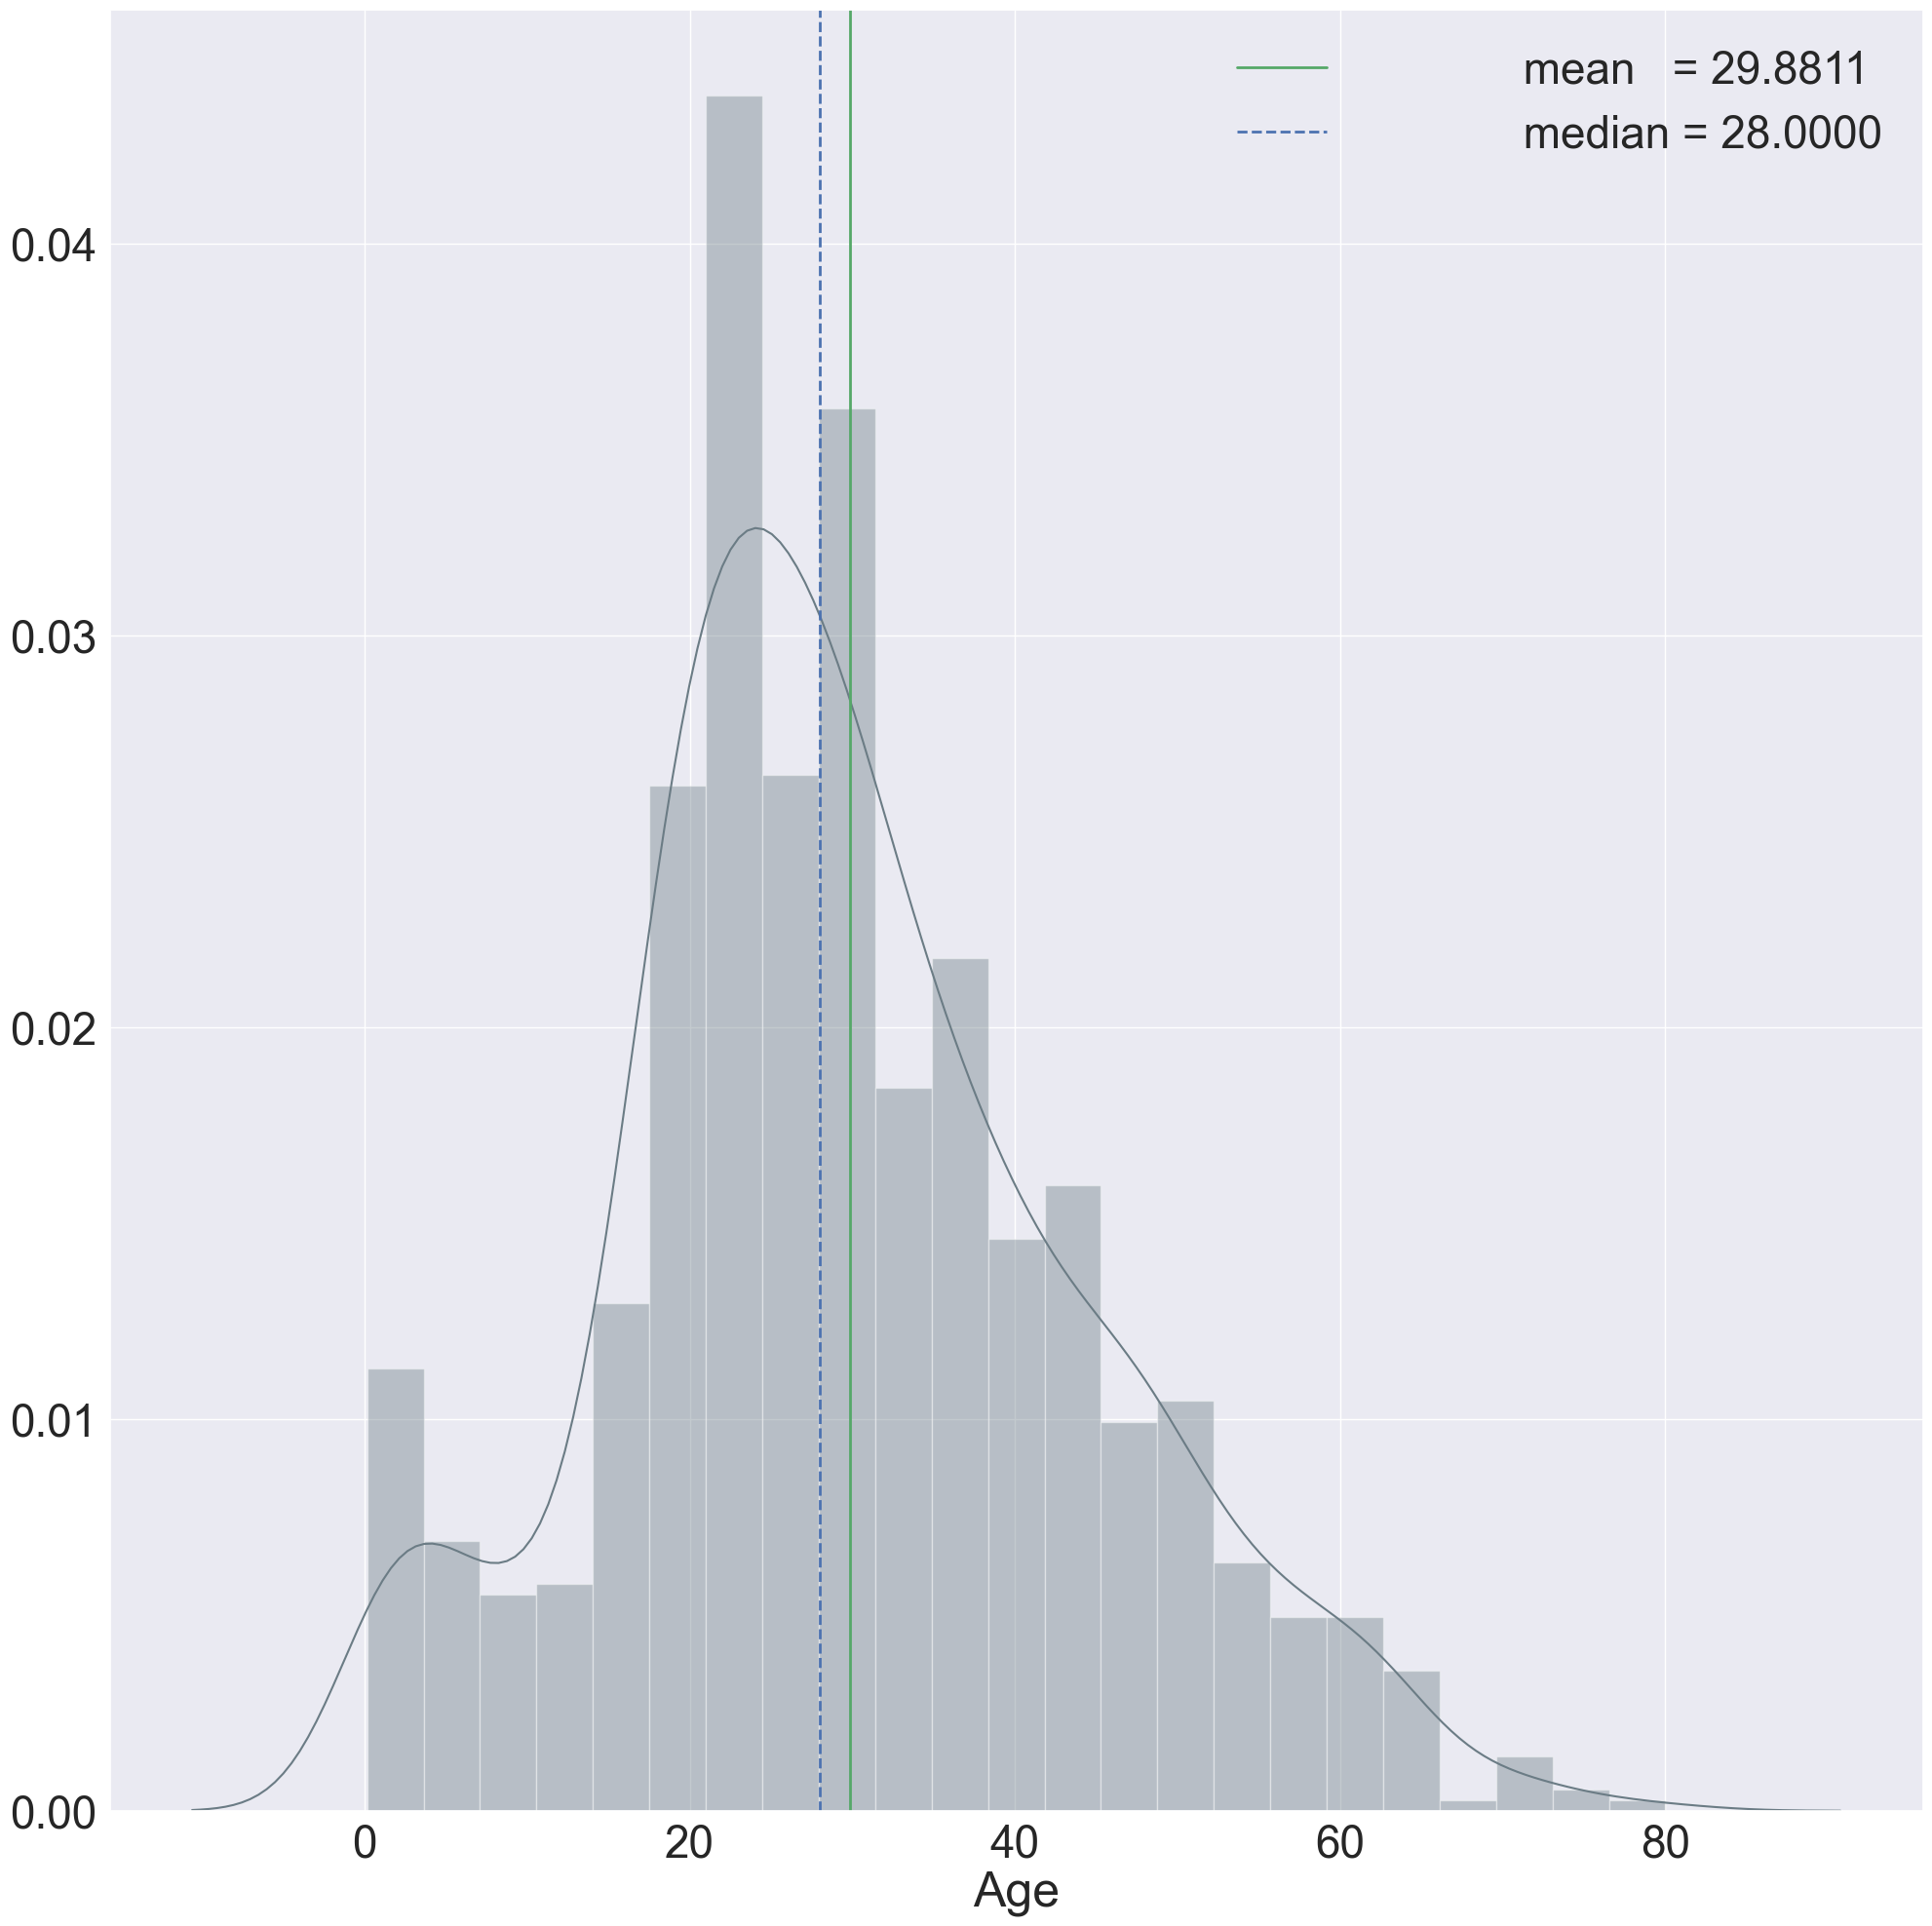

In [64]:
fig, ax = plt.subplots(1,1, figsize=(24,24));
affichageDistribution(donnees.Age,"#6b7c85",ax)

In [65]:
donnees.sample(5)

,Survived,Classe,Name,Sex,Age,ConjointsOuFratrie,EnfantsOuParents,Ticket,Fare,Cabine,Port,Title,TailleFamille,Pont,TicketNum,TitreFamille,GroupFamille,GroupFamilleFreq,GroupFemmeEnfant,GroupFemmeEnfantFreq,GroupFemmeEnfGouv,GroupFemmeEnfGouvFreq
PassengerId,,,,,,,,,,,,,,,,,,,,,,
125,Non,Supérieure,White,Homme,54.0,0,1,Vide,77.2875,1,Southampton,Mr,2,D,35281,Homme,White-Supérieure-Southampton-Vide,2,Sans Groupe,0,Sans Groupe,0
413,Oui,Supérieure,Minahan,Femme,33.0,1,0,Vide,90.0000,1,Queenstown,Miss,2,C,19928,Femme,Minahan-Supérieure-Queenstown-Vide,3,Minahan-Supérieure-Queenstown-Vide,2,Supérieure-Queenstown-19928,2
1086,Test,Moyenne,Drew,Homme,8.0,0,2,Vide,32.5000,0,Southampton,Master,3,Vide,28220,Garçon,Drew-Moyenne-Southampton-Vide,3,Drew-Moyenne-Southampton-Vide,2,Moyenne-Southampton-28220,2
149,Non,Moyenne,Navratil,Homme,36.5,0,2,Vide,26.0000,1,Southampton,Mr,3,F,230080,Homme,Navratil-Moyenne-Southampton-Vide,3,Sans Groupe,0,Sans Groupe,0
1092,Test,Inférieure,Murphy,Femme,NaN,0,0,Vide,15.5000,0,Queenstown,Miss,1,Vide,36568,Femme,Sans Groupe,0,Sans Groupe,0,Inférieure-Queenstown-36568,1


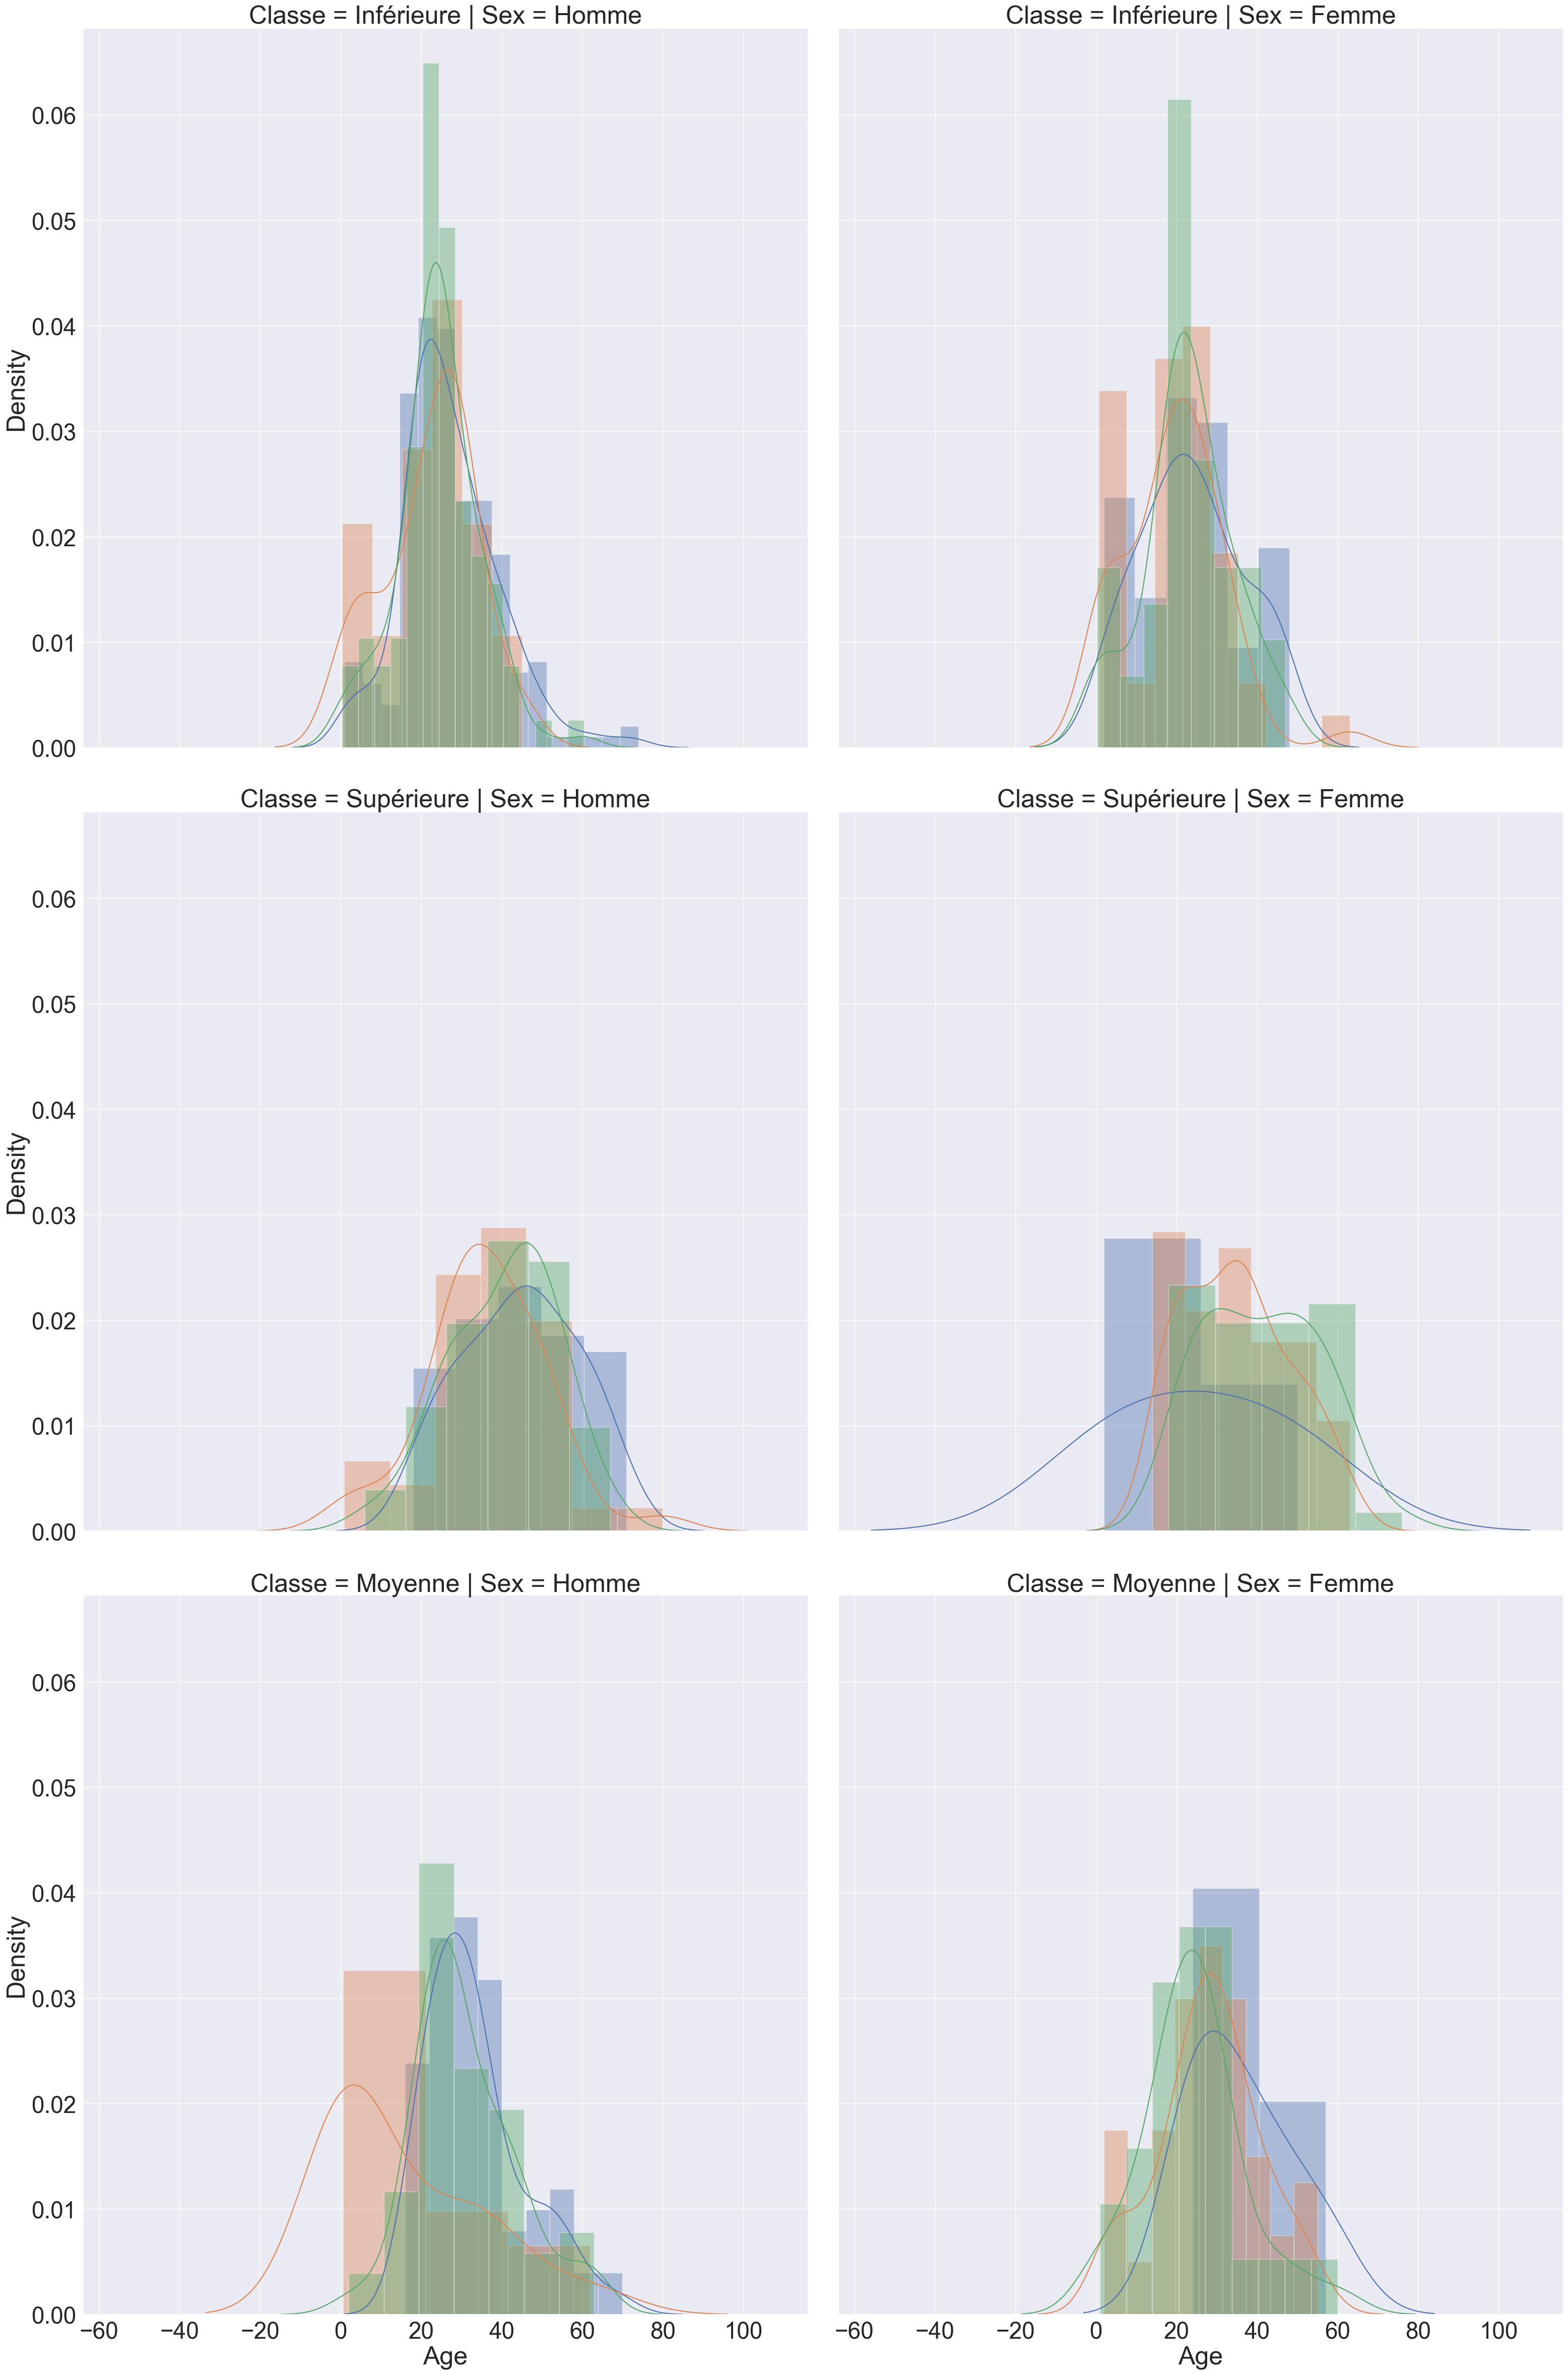

In [66]:
sns_plot = sns.FacetGrid(data=donnees[~donnees.Age.isna()],
                  col='Sex',row='Classe', hue='Survived',height=16,aspect=1);
sns_plot.map(sns.distplot,'Age');

In [67]:
donnees['AgeOld'] = donnees.Age

In [68]:
ageMedian = donnees.groupby(['Sex','Classe']).agg({'Age':'median'}).rename(columns={'Age':'AgeM'}).reset_index()
ageMedian

,Sex,Classe,AgeM
0,Femme,Inférieure,22.0
1,Femme,Moyenne,28.0
2,Femme,Supérieure,36.0
3,Homme,Inférieure,25.0
4,Homme,Moyenne,29.5
5,Homme,Supérieure,42.0


In [69]:
donnees = donnees.reset_index().merge(ageMedian,on=['Sex','Classe'],how='left').set_index('PassengerId')

In [70]:
donnees.loc[donnees.Age.isna(),'Age'] = donnees.loc[donnees.Age.isna(),'AgeM']

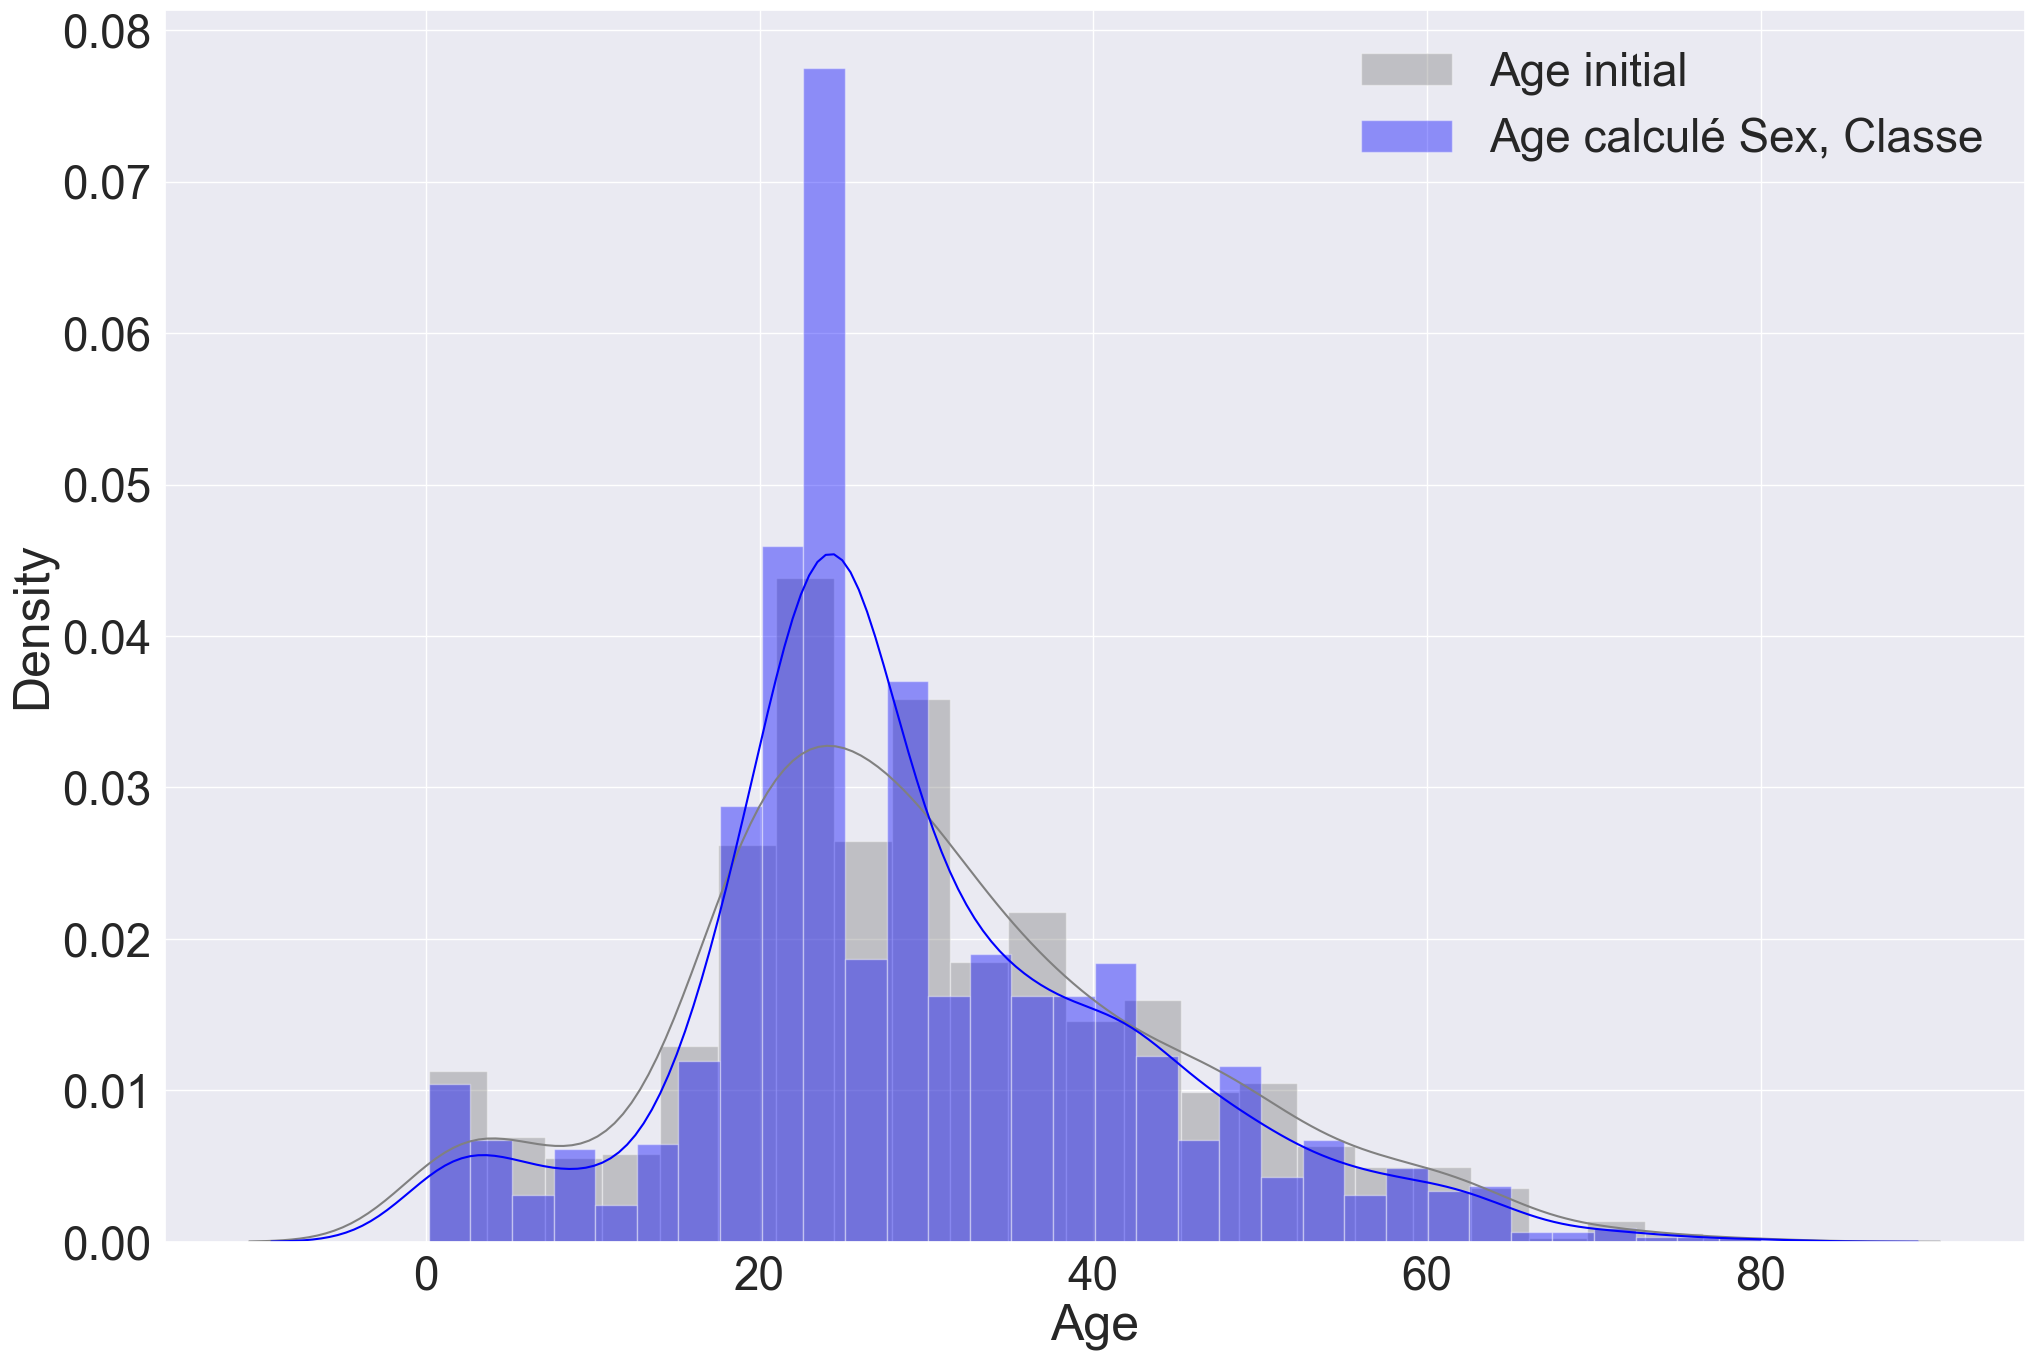

In [71]:
plt.figure(figsize=(24,16))
sns.distplot(donnees.AgeOld ,color='grey', label="Age initial");
sns.distplot(donnees.Age ,color='blue', label="Age calculé Sex, Classe");
plt.legend();

In [72]:
donnees.drop(columns=['AgeOld', 'AgeM'],inplace=True)

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Statistiques descriptives et analyse de données</div></b>

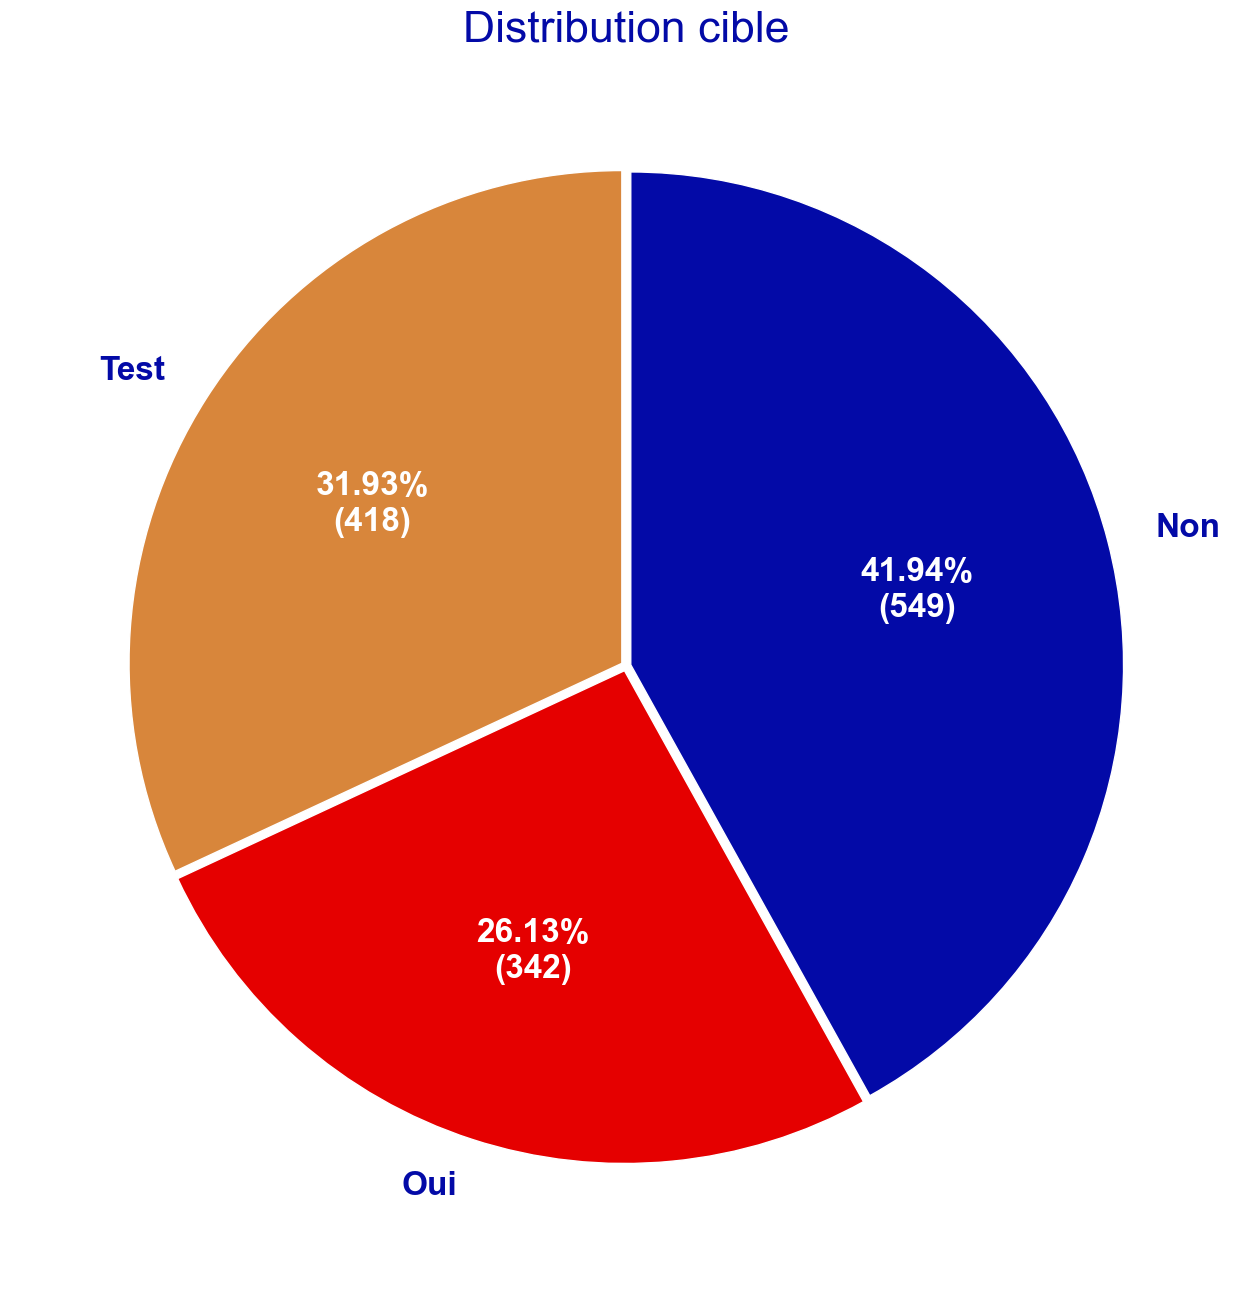

In [73]:
radius,size=0.8,0.3
fig,ax = plt.subplots(ncols=1,figsize=(16,16), subplot_kw=dict(aspect="equal"))

affichage = donnees.groupby('Survived').Name.count().reset_index().rename(columns={'Name':'nombre'})
affichage['%'] = affichage.nombre * 100 / affichage.nombre.sum()
affichage

wedges, texts, autotexts =  ax.pie(
         affichage['nombre'],
         autopct=lambda pct: formatPct(pct, affichage.nombre.values),   # autopct='%1.2f%%', 
         labels=affichage.Survived.values,
         # shadow=True, 
         counterclock=False,
         startangle=90 ,
         colors = palette,
         # pctdistance=0.4, 
         labeldistance=1.1, 
         textprops=dict(color="#030aa7"),
         explode=[0.01 for _ in range(affichage.Survived.count())]
      );
plt.setp(autotexts, size=24, weight="bold",color="w")
plt.setp(texts, size=24, weight="bold");
ax.set_title("Distribution cible",fontdict=dict(color="#030aa7", size=32));

In [74]:
affichage = donnees[donnees.Survived != 'Test'].groupby(['Survived', 'Port', 'Classe', 'Sex']).Name.count().reset_index().rename(columns={'Name':'nombre'})
affichage['%'] = affichage.nombre * 100 / affichage.nombre.sum()
affichage

fig = go.Figure(px.treemap(affichage, 
                           path=[px.Constant("Global"), 'Survived', 'Port', 'Classe', 'Sex'], values='nombre',
                           color='nombre', 
                           hover_data=['Survived', 'Port', 'Classe', 'Sex'],
                  color_continuous_scale='RdBu',
                  color_continuous_midpoint=affichage['nombre'].mean(),
                 width=1152,
                 height=768
                ))
fig.show()

In [75]:
affichage = donnees[donnees.Survived != 'Test'].groupby(['Survived', 'Port','GroupFemmeEnfGouvFreq']).Name.count().reset_index().rename(columns={'Name':'nombre'})
affichage['%'] = affichage.nombre * 100 / affichage.nombre.sum()
affichage

fig = go.Figure(px.treemap(affichage, 
                           path=[px.Constant("Global"), 'Survived', 'Port','GroupFemmeEnfGouvFreq'], values='nombre',
                           color='nombre', 
                           hover_data=['Survived', 'Port','GroupFemmeEnfGouvFreq'],
                  color_continuous_scale='RdBu',
                  color_continuous_midpoint=affichage['nombre'].mean(),
                 width=1152,
                 height=768
                ))
fig.show()